# Выпускной проект
_по курсу "Аналитик данных"_

## Материалы
[Презентация](https://disk.yandex.ru/i/ATAhRTrEf-iixA)

<a id="описание"></a>
## Описание проекта

Задача проекта — сегментировать покупателей по профилю потребления, чтобы подготовить рекомендации по SMS-рассылкам (кому, когда и какие категории товаров предлагать). Нужно провести ИАД, разбить покупателей на релевантные и бизнес-ориентированные сегменты, проверить статистические гипотезы по этим кластерам, написать рекомендации по ним и подготовить презентацию в PDF.

### Описание данных

Датасет описывает транзакции интернет-магазина товаров для дома и быта «Пока все ещё тут»:  
date — дата заказа;  
customer_id — идентификатор покупателя;  
order_id — идентификатор заказа;  
product — наименование товара;  
quantity — количество товара в заказе;  
price — цена товара.

<a id='оглавление'></a>
## Оглавление
- [Описание проекта](#описание)
- [Оглавление](#оглавление)
- [Загрузка библиотек и данных](#загрузка)
- [Подготовка (предобработка) данных](#предобработка)
- [Исследовательский анализ данных (EDA)](#исследовательский-анализ-данных-eda)
- [Сегментация](#сегментация)
- [Проверка гипотез](#проверка-гипотез)
- [Анализ покупок и сезонности внутри сегментов](#анализ_сезонности)
- [Заключение](#заключение)

<a id='загрузка'></a>
## Загрузка библиотек и данных

In [1]:
# загружаю нужные для работы библиотеки

import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import seaborn as sns
from scipy.stats import shapiro, kruskal

In [2]:
# загружаю данные

url = "https://code.s3.yandex.net/datasets/ecom_dataset_upd.csv"
data = pd.read_csv(url)

In [3]:
# проверяю данные

data.sample(5)

,date,customer_id,order_id,product,quantity,price
3553,2019051219,3d5fef90-4a65-4a7e-84cf-010eba7b038d,14753,Базилик Овощной Арарат d-7 см,1,15.0
4924,2019060910,1d6c8c1f-a799-4418-9af2-1ded47d7a85c,14833,"Рассада Кабачка сорт Горный, кассета по 6шт",1,120.0
6351,2019091810,05257dd3-0c7e-4b4c-a86d-786558162d11,72681,Гортензия Микс в кашпо с автополивом,1,3599.0
539,2018103021,7c769d6c-869c-4200-b3a6-c33ef2d7723f,68805,Утюг электрический с керамическим покрытием DE...,1,1199.0
3042,2019042313,48788184-498b-49da-955e-7737bf7c9047,71247,Искусственный цветок Роза закрытая малая пласт...,1,22.0


In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7474 entries, 0 to 7473
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   date         7474 non-null   int64  
 1   customer_id  7474 non-null   object 
 2   order_id     7474 non-null   int64  
 3   product      7474 non-null   object 
 4   quantity     7474 non-null   int64  
 5   price        7474 non-null   float64
dtypes: float64(1), int64(3), object(2)
memory usage: 350.5+ KB


В нашем пользовании датасет с данными на 6 столбцов и 7474 строки.

[Назад к оглавлению](#оглавление)

<a id='предобработка'></a>
## Подготовка (предобработка) данных

### Проверка и преобразование типов данных

In [5]:
data.dtypes

date             int64
customer_id     object
order_id         int64
product         object
quantity         int64
price          float64
dtype: object

Столбец date на данный момент в формате int64. Для корректной последующей работы с датой конвертирую его в datetime.

In [6]:
# меняю тип данных столбца date на datetime

data['date'] = pd.to_datetime(data['date'].astype(str), format='%Y%m%d%H')

In [7]:
# проверяю, что конвертация проведена корректно

data['date']

0      2018-10-01 00:00:00
1      2018-10-01 00:00:00
2      2018-10-01 00:00:00
3      2018-10-01 00:00:00
4      2018-10-01 00:00:00
               ...        
7469   2020-01-30 21:00:00
7470   2020-01-30 22:00:00
7471   2020-01-31 02:00:00
7472   2020-01-31 12:00:00
7473   2020-01-31 15:00:00
Name: date, Length: 7474, dtype: datetime64[ns]

Тип данных столбца customer_id - object - на первый взгляд выглядит некорректно. Но так как в идентификаторах клиентов используются и буквы, то оставляю его, как есть.  

А вот тип данных столбца order_id поменяю с int64 на str. Таким образом я снижаю риск случайно просуммировать данные этого столбца (или провести другие некорректные математические операции).

In [8]:
# меняю тип данных столбца order_id

data['order_id'] = data['order_id'].astype(str)

In [9]:
# проверяю, что изменение проведено корректно

data.dtypes

date           datetime64[ns]
customer_id            object
order_id               object
product                object
quantity                int64
price                 float64
dtype: object

### Работа с пропусками и дубликатами

In [10]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7474 entries, 0 to 7473
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   date         7474 non-null   datetime64[ns]
 1   customer_id  7474 non-null   object        
 2   order_id     7474 non-null   object        
 3   product      7474 non-null   object        
 4   quantity     7474 non-null   int64         
 5   price        7474 non-null   float64       
dtypes: datetime64[ns](1), float64(1), int64(1), object(3)
memory usage: 350.5+ KB


В нашем датасете нет пропусков, что, на первый взгляд, большая удача, но в то же время заставляет присмотреться к данным еще более внимательно. Для начала проверю данные на наличие полных дубликатов.

In [11]:
data.duplicated().sum()

0

Полных дубликатов нет. Теперь проверю датасет на неполные дубликаты.

In [12]:
data[data.duplicated(subset=['customer_id','order_id','product','quantity', 'price'])].sort_values(by='date')

,date,customer_id,order_id,product,quantity,price
58,2018-10-02 18:00:00,b731df05-98fa-4610-8496-716ec530a02c,68474,Доска гладильная Eurogold Professional 130х48 ...,1,3299.0
59,2018-10-02 19:00:00,b731df05-98fa-4610-8496-716ec530a02c,68474,Доска гладильная Eurogold Professional 130х48 ...,1,3299.0
60,2018-10-02 20:00:00,b731df05-98fa-4610-8496-716ec530a02c,68474,Доска гладильная Eurogold Professional 130х48 ...,1,3299.0
63,2018-10-03 04:00:00,b731df05-98fa-4610-8496-716ec530a02c,68474,Доска гладильная Eurogold Professional 130х48 ...,1,3299.0
94,2018-10-04 13:00:00,32de7df8-8d4f-4c84-a7b9-c41d00dd83ba,68522,Эвкалипт Гунни d-17 см h-60 см,1,1409.0
...,...,...,...,...,...,...
6706,2019-10-28 10:00:00,57cc80a2-2610-4eef-9457-e7c3bf0c72f0,70960,Сумка-тележка 2-х колесная Gimi Argo красная,1,1087.0
6711,2019-10-28 21:00:00,cb65d08a-dae7-4890-aef0-bb9f79055e02,73108,Мирт d-9 см h-15 см,1,134.0
6728,2019-10-31 00:00:00,ffaeab76-3a8d-49ee-860f-17273b2fc8a2,73136,"Таз пластмассовый со стиральной доской (Иж), 1...",1,397.0
6729,2019-10-31 02:00:00,ffaeab76-3a8d-49ee-860f-17273b2fc8a2,73136,"Таз пластмассовый со стиральной доской (Иж), 1...",1,397.0


In [13]:
# проверяю отдельный пример
data[data['order_id'] == '68522']

,date,customer_id,order_id,product,quantity,price
80,2018-10-04 09:00:00,32de7df8-8d4f-4c84-a7b9-c41d00dd83ba,68522,Эвкалипт Гунни d-17 см h-60 см,1,1409.0
94,2018-10-04 13:00:00,32de7df8-8d4f-4c84-a7b9-c41d00dd83ba,68522,Эвкалипт Гунни d-17 см h-60 см,1,1409.0


In [14]:
# проверяю, сколько уникальных номеров заказа есть в датасете до обработки дубликатов
data['order_id'].nunique()

3521

In [15]:
# оставляю только первый заказ из каждого сета неполных дубликатов с одинаковой датой
data = data.sort_values(by='date').drop_duplicates(
    subset=['customer_id', 'order_id', 'product', 'quantity', 'price'],
    keep='first'
)

In [16]:
data[data.duplicated(subset=['customer_id','order_id','product','quantity', 'price'])].sort_values(by='date')

,date,customer_id,order_id,product,quantity,price


In [17]:
# проверяю, что количество уникальных номеров заказа осталось прежним
data['order_id'].nunique()

3521

In [18]:
# проверяю, сколько строк осталось в датасете
len(data)

5610

In [19]:
# проверяю дубликаты с одинаковыми наименованиями и номерами заказа
data[data.duplicated(subset=['order_id','product'], keep=False)].sort_values(['order_id','product'])

,date,customer_id,order_id,product,quantity,price
4157,2019-05-31 12:00:00,1d6c8c1f-a799-4418-9af2-1ded47d7a85c,14833,"Рассада Кабачка сорт Аэронавт, кассета по 6шт",1,120.0
4390,2019-06-03 13:00:00,1d6c8c1f-a799-4418-9af2-1ded47d7a85c,14833,"Рассада Кабачка сорт Аэронавт, кассета по 6шт",2,120.0
4158,2019-05-31 12:00:00,1d6c8c1f-a799-4418-9af2-1ded47d7a85c,14833,Рассада Кабачка сорт Белогор кассета 6 шт E6,1,120.0
4391,2019-06-03 13:00:00,1d6c8c1f-a799-4418-9af2-1ded47d7a85c,14833,Рассада Кабачка сорт Белогор кассета 6 шт E6,2,120.0
4159,2019-05-31 12:00:00,1d6c8c1f-a799-4418-9af2-1ded47d7a85c,14833,"Рассада Кабачка сорт Горный, кассета по 6шт",1,120.0
...,...,...,...,...,...,...
6505,2019-10-03 15:00:00,0309d37c-ab5f-4793-ba72-5484c019b840,72845,Муляж Яблоко зеленый 9 см полиуретан,40,59.0
6508,2019-10-04 08:00:00,25a8cd52-3efa-48ee-a6bd-d413d7e2b42f,72845,Муляж Яблоко зеленый 9 см полиуретан,40,59.0
6538,2019-10-07 20:00:00,2ac05362-3ca7-4d19-899c-7ba266902611,72845,Муляж Яблоко зеленый 9 см полиуретан,40,59.0
6601,2019-10-13 15:00:00,b1dbc7c4-3c84-40a7-80c9-46e2f79d24ad,72950,Кастрюля эмалированная Стэма С-1624 12 л цилин...,1,974.0


In [20]:
# проверяю, какую долю от всего датасета составляют эти данные
data.duplicated(subset=['order_id','product'], keep=False).sum() / data.shape[0] * 100

1.9429590017825311

In [21]:
# так как мы не можем достоверно установить, какой заказ корректный, удаляю все (доля небольшая)
data = data[~data.duplicated(subset=['order_id','product'], keep=False)]

In [22]:
data[data.duplicated(subset=['order_id','product'], keep=False)].sort_values(['order_id','product'])

,date,customer_id,order_id,product,quantity,price


In [23]:
data.shape

(5501, 6)

### Проверка числовых признаков

В этом подразделе проверю, что в столбцах с числовыми признаками не было некорректных (нулевых/отрицательных) значений там, где их не должно быть.

In [24]:
(data['quantity'] <= 0).sum()  # сколько нулей/отрицательных

0

In [25]:
(data['quantity'] % 1 != 0).sum()  # сколько нецелых

0

In [26]:
(data['price'] <= 0).sum() # есть ли отрицательная цена

0

In [27]:
data['price'].describe()

count     5501.000000
mean       532.936936
std        976.694622
min          9.000000
25%         90.000000
50%        150.000000
75%        524.000000
max      14917.000000
Name: price, dtype: float64

<AxesSubplot:>

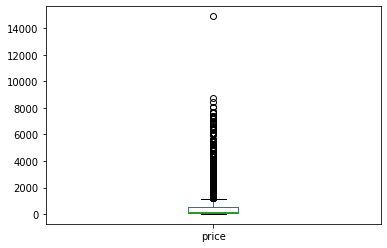

In [28]:
data['price'].plot(kind='box')

И на графике, и в таблице сразу выделяется значение цены в 14917 рублей, что очень выбивается из ряда других цен в выборке.

In [29]:
# проверяю самый заметный выброс
data[data['price'] == 14917]

,date,customer_id,order_id,product,quantity,price
5992,2019-07-29 17:00:00,0d87f4ae-465a-4fac-81e6-5d629761783e,72139,Сушилка уличная Leifheit 85210 LINOMATIC V 400...,1,14917.0


Сушилки по такой стоимости действительно существуют, и даже дороже, оставляю эту строку.

In [30]:
# добавляю колонку с общей стоимостью заказа
data['total_cost'] = data['price'] * data['quantity']

In [31]:
# проверяю эту колонку
data['total_cost'].describe()

count      5501.000000
mean        833.349103
std        9241.845110
min           9.000000
25%         120.000000
50%         191.000000
75%         734.000000
max      675000.000000
Name: total_cost, dtype: float64

<AxesSubplot:>

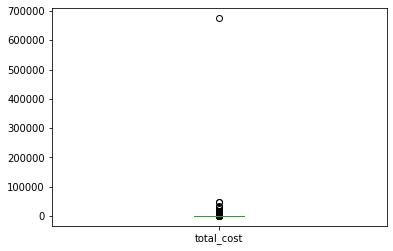

In [32]:
data['total_cost'].plot(kind='box')

А здесь выделяется заказ на общую сумму 675000, который значительно выбивается из ряда всех остальных заказов.

In [33]:
# проверяю выброс
data[data['total_cost'] > 100000]

,date,customer_id,order_id,product,quantity,price,total_cost
5456,2019-06-18 15:00:00,312e9a3e-5fca-43ff-a6a1-892d2b2d5ba6,71743,"Вантуз с деревянной ручкой d14 см красный, Bur...",1000,675.0,675000.0


In [34]:
# проверяю заказ, к которому относится этот выброс
data[data['order_id'] == '71743']

,date,customer_id,order_id,product,quantity,price,total_cost
5456,2019-06-18 15:00:00,312e9a3e-5fca-43ff-a6a1-892d2b2d5ba6,71743,"Вантуз с деревянной ручкой d14 см красный, Bur...",1000,675.0,675000.0


In [35]:
data[data['customer_id'] == '312e9a3e-5fca-43ff-a6a1-892d2b2d5ba6']

,date,customer_id,order_id,product,quantity,price,total_cost
5456,2019-06-18 15:00:00,312e9a3e-5fca-43ff-a6a1-892d2b2d5ba6,71743,"Вантуз с деревянной ручкой d14 см красный, Bur...",1000,675.0,675000.0


У этого клиента всего один заказ и он выглядит подозрительно (1000 вантузов, заказанная одним клиентом, при этом это единственный заказ этого клиента в выборке), поэтому удалю его из датасета, чтобы он не сбивал данные.

In [36]:
data = data.drop(5456)

<AxesSubplot:>

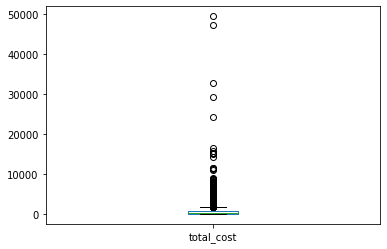

In [37]:
data['total_cost'].plot(kind='box')

На всякий случай еще проверю заказы стоимостью > 20000 р., так как на графике они тоже похожи на выбросы, но по факту это могут быть просто редкие дорогие заказы.

In [38]:
data[data['total_cost'] > 20000]

,date,customer_id,order_id,product,quantity,price,total_cost
661,2018-11-06 12:00:00,1b2764ad-9151-4051-a46a-9b01b62e6335,68878,"Урна уличная ""Гео"", Hobbyka/Хоббика, 59*37,5см...",5,4874.0,24370.0
1023,2018-11-29 17:00:00,8fba3604-ef57-4b9f-b2fe-3402fa8825c8,69156,Набор ножей Attribute CHEF 5 предметов AKF522,64,457.0,29248.0
1299,2018-12-21 16:00:00,6987e6d6-a63a-4ce2-a2d0-f424092d235e,69504,Тележка багажная DELTA ТБР-22 синий грузоподъе...,57,574.0,32718.0
1518,2019-01-15 13:00:00,58a4c3cc-504f-43ea-a74a-bae19e665552,69830,Простынь вафельная 200х180 см WELLNESS RW180-0...,27,1755.0,47385.0
5071,2019-06-11 07:00:00,146cd9bf-a95c-4afb-915b-5f6684b17444,71668,Вешалки мягкие для деликатных вещей 3 шт шоколад,334,148.0,49432.0


Эти заказы выглядят уже не так подозрительно - все эти товары вполне могли заказать отели/магазины

### Добавление новых колонок

In [39]:
# добавляю колонку с обозначением месяца заказа
data['month'] = data['date'].dt.to_period('M').astype(str)

In [40]:
# создаю функцию, чтобы обозначить время года, когда был произведен заказ

def get_season(month_num):
    if month_num in [12, 1, 2]:
        return '1_зима'
    elif month_num in [3, 4, 5]:
        return '2_весна'
    elif month_num in [6, 7, 8]:
        return '3_лето'
    else:
        return '4_осень'

data['season'] = data['date'].dt.month.apply(get_season)

In [41]:
# проверяю, что значения в новых столбцах корректны
data[['date', 'month', 'season']].sample(5)

,date,month,season
1309,2018-12-22 21:00:00,2018-12,1_зима
4077,2019-05-28 09:00:00,2019-05,2_весна
794,2018-11-12 14:00:00,2018-11,4_осень
348,2018-10-21 22:00:00,2018-10,4_осень
2755,2019-04-09 11:00:00,2019-04,2_весна


### Разбивка товаров на категории

In [42]:
# для унификации привожу наименования товаров к нижнему регистру
data['product'] = data['product'].str.lower()

In [43]:
data['product'].nunique()

2327

В нашем датасете 2329 уникальных наименований товаров. Так как нам потребуется анализировать сезонность продаж, имеет смысл разбить эти товары на более крупные категории для агрегации данных.

In [44]:
categories_dict = {
    "кухонная утварь и посуда": [
        'тарелка', 'нож', 'салатник', 'чайник', 'рыбочистка',
        'термостакан', 'котел', 'салфетница', 'рассекатель', 'дуршлаг', 'бульонница', 'скалка',
        'тортница', 'сотейник', 'отделитель', 'сахарница', 'половник', 'бидон', 'блюдо', 'блюдце',
        'вилка', 'разделочная', 'емкость', 'измельчитель', 'картофелемялка',
        'кастрюля', 'кипятильник', 'кисточка', 'хлебница', 'кружка', 'крышка', 'кувшин',
        'кухонное', 'кухонные', 'столов', 'чайная', 'холодца', 'мантоварка', 'пароварка', 'лопатка',
        'масленка', 'мерный', 'стакан', 'миксер', 'миска', 'бокалов',
        'для пикника', 'фужер', 'ножеточка', 'овощеварка', 'овощечистка', 'просеиватель',
        'противень', 'сковород', 'скребок кондитерский', 'соковарка', 'соковыжималка', 'тepмокружка',
        'терка', 'толкушка', 'форма', 'кухонная', 'сито', 'подставка для яйца',
        'орехоколка', 'чайный', 'кексов', 'пресс для чеснока', 'кружек для пива', 'термос', 'лоток', 'подставка для ножей',
        'венчик', 'набор посуды', 'электроштопор', 'ковш', 'защитный', 'шприц', 'овощей', 'герметичный', 'продуктов', 'свч', 'яиц'
    ],

    "уборка, глажка, бытовая химия": [
        'гладильная доска', 'доска гладильная', 'таз', 'щетка', 'ведр',
        'насадка-', 'насадка для', 'насадка к', 'насадка на', 'ополаскиватель', 'антинакипин', 'веник',
        'гель', 'прищеп', 'губка', 'соль', 'кондиционер', 'мусор', 'стирки',
        'мытья', 'швабр', 'совок', 'сетка',
        'антижир', 'пылесос', 'сушилк', 'подрукавник', 'совком', 'ролик для чистки',
        'мыть', 'средство', 'утюг', 'тряпка', 'корыто',
        'вантуз', 'сменный', 'сметка', 'скребок для окон', 'скребок 44 см', 'окномойка', 'чистящий',
        'ерш', 'отбеливатель', 'стиральный', 'запасная', 'тряпкодержатель', 
        'салфетки', 'ткань универсальная', 'ёрш', 'засор', 'для гладильной', 'ткань для', 'чехол eurogold'
    ],
    
    "товары для ванной и ухода за собой": [
        'ванна', 'для ванной и туалета', 'крем', 'мыльница', 'подголовник', 'штора текстильная',
        'пробка', 'сиденье для унитаза', 'зубная', 'мыло жидкое', 'жидкое мыло', 'мыло-скраб', 'мыло ручной работы','увлажняющая',
        'фен дорожный', 'пена', 'держатель для', 'дозатор', 'сиденье', 'штанга', 'штора для ванной', 'карниз для ванной', 'кольца'
    ],

    "текстиль, интерьер и декор": [
        'муляж', 'искусственный', 'штор', 'скатерть', 'подушка', 'покрывало', 'постель',
        'искусственная', 'декоративная композиция', 'новогоднее', 'подарочный', 'ваза', 'фоторамка',
        'ковер', 'ковёр', 'ковр', 'махровое',
        'халат', 'наволочка', 'наматр', 'одеяло', 'плед', 'подкладка', 
        'простын', 'пододеяльник', 'полотен', 'махровых салфеток', 'салфетка'
    ],
    
    "инструменты и хозяйственные мелочи": [
        'стремянк', 'веревка', 'инструмент', 'свер',
        'напильник', 'стяжка', 'шпингалет', 'сварка', 'крепеж', 'пружин', 'петля',
        'линейка', 'паста для полировки', 'бензин', 'завертка', 'лестница', 
        'шнур', 'строительное', 'пьезозажигалка',
        'ручка-скоба', 'стяжка', 'термометр', 'уголок', 
        'шило', 'штангенциркуль', 'основание для пробки', 'тележ',
        'фал капроновый', 'перчатки', 'сумка', 'решетка', 'стяжки', 'шпагат'
    ],
    
     "хранение и организация в доме": [
        'вешал', 'крючок', 'фиксатор-шар', 'ключница',
        'вакуумный', 'весы', 'вкладыши', 'коробка', 'кофр', 'обувная',
        'плечики', 'полк',
        'стеллаж', 'урна', 'этажерка', 'ящик', 'комод', 'карниз', 'пуф',
        'светиль', 'банка', 'корзина', 'обув', 'ручка мебельная', 'чехол для одежды', 'чехол для платья', 'чехол для костюма', 'чехол для короткой'
    ],

    "растения, семена и сад": [
        'рассада', 'томат', 'помидор', 'пеларгония', 'роза', 'петуния', 'раннеспелый',
        'капуста', 'герань', 'огурец', 'мята', 'фуксия', 'примула', 'калибрахоа',
        'тимьян', 'цикламен', 'флокс', 'цинния', 'калатея', 'мимоза стыдливая', 'глоксиния',
        'афеляндр', 'кореопсис', 'цинерария', 'диффенбахий', 'диффенбахия', 'эхинокактус',
        'лилейник высокорослый', 'гиацинт', 'фатсия', 'каллуна', 'капсикум', 'соланум',
        'подсолнечник', 'алоэ', 'аптения', 'кодонант', 'укроп', 'смолевка', 'вербейник',
        'эхинацея', 'папоротник', 'платикодон', 'энотера', 'цитрофортунелла', 'пеперомия',
        'синнингия', 'пиретрум', 'драцена', 'гайлардия', 'нивянник', 'физостегия', 'лавр',
        'вигна', 'хамедорея', 'настурция', 'а патио', 'адиантум', 'азалия', 'аквилегия',
        'алиссум', 'амариллис', 'альбука', 'андесса', 'арбуз', 'артемизия', 'аспарагус',
        'астра', 'бадан', 'базилик', 'баклажан', 'бакопа', 'бальзам', 'барвинок', 'бархатцы',
        'бегония', 'буддлея', 'бузульник', 'валериана', 'вербена', 'виола', 'газания',
        'гвоздика', 'гардения', 'георгина', 'гербера', 'гимнокалициум', 'гиностемма',
        'гипсофила', 'годеция', 'горох', 'гортензия', 'декабрист', 'декоративная', 'дендробиум',
        'джункус', 'томата', 'дыня', 'ель', 'чабер', 'замиокулькас', 'зверобой', 'земляника',
        'змееголовник', 'импатиенс', 'иссоп', 'сантолина', 'кабачок', 'каланхое', 'календула',
        'калла', 'калоцефалус', 'камнеломка', 'кампанула', 'кипарисовик', 'клен', 'клубника',
        'колокольчик', 'растение', 'кориандр', 'космея', 'крассула', 'крокусы', 'лаванда',
        'лантана', 'лапчатка', 'лен', 'литопс', 'порей', 'львиный', 'зев', 'любисток',
        'мединилла', 'мелисса', 'многолетнее', 'молодило', 'петрушка', 'незабудка', 'нолина',
        'однолетнее', 'осина', 'патиссон', 'пахира', 'подвесное', 'портулак',
        'пуансеттия', 'радермахера', 'розмарин', 'рудбекия', 'скиммия', 'спатифиллум',
        'суккулент', 'сциндапсус', 'тюльпан', 'ранункулус', 'тыква', 'фаленопсис', 'фиалка',
        'фикус', 'фиттония', 'хризантема', 'целозия', 'шалфей', 'эвкалипт', 'эпипремнум',
        'эхеверия', 'эшшольция', 'ясколка', 'шеффлера', 'хризолидокарпус', 'циперус',
        'юкка нитчатая', 'нефролепис', 'овсянница сизая серый', 'хлорофитум', 'мускари',
        'котовник', 'антуриум', 'душица', 'пуансетия', 'морковь детская', 'девичий виноград',
        'лобелия', 'муррайя', 'вероника колосковая', 'хоста', 'монарда', 'пряные травы', 'седум',
        'солидаго', 'лаватера', 'анемона', 'табак', 'салат рукола', 'мирт', 'арабика', 'подставка для цветов'
    ]   
}

In [45]:
# создаю функцию, которая присвоит каждому наименованию категорию в соответствии с созданным мной словариком
def categorize_product(product_name):
    for category, keywords in categories_dict.items():
        for kw in keywords:
            if kw in product_name:
                return category
    return "Прочее"

data["category"] = data["product"].apply(categorize_product)

In [46]:
# убеждаюсь, что товарам присвоены четкие категории и ни одно наименование не оказалось в категории "прочее"
data[data['category'] == 'Прочее']

,date,customer_id,order_id,product,quantity,price,total_cost,month,season,category


In [47]:
data.sample(20)

,date,customer_id,order_id,product,quantity,price,total_cost,month,season,category
365,2018-10-22 22:00:00,662f1eae-7111-44f3-aa45-797eee140546,68721,мелисса лекарственная d-9 см,1,112.0,112.0,2018-10,4_осень,"растения, семена и сад"
311,2018-10-18 17:00:00,3de09660-90bc-4a28-aaf1-34c8435fe59c,68683,"таз пластмассовый 16,0 л пищевой с ручками (с2...",1,269.0,269.0,2018-10,4_осень,"уборка, глажка, бытовая химия"
3995,2019-05-22 13:00:00,29655d47-d948-4b42-aeb9-2c10cc8fc09c,14809,пеларгония зональная диам. 12 см малиново-крас...,5,150.0,750.0,2019-05,2_весна,"растения, семена и сад"
3943,2019-05-20 17:00:00,4856a2a7-b9d2-4243-b8d9-a96ec1425bbe,14798,рассада огурец фараон ячейки по 6 шт е6,1,120.0,120.0,2019-05,2_весна,"растения, семена и сад"
5698,2019-07-05 14:00:00,4a3e8c01-1d47-4867-8a7f-14195a8dbb3d,14893,лавр в горшке 7 см,1,38.0,38.0,2019-07,3_лето,"растения, семена и сад"
2665,2019-04-04 12:00:00,dc4dd46a-e2e9-4be5-883c-a2f6bd0c655c,14616,пеларгония зональная диам. 12 см темнорозовая ...,1,188.0,188.0,2019-04,2_весна,"растения, семена и сад"
3064,2019-04-24 05:00:00,e7583f5b-0989-4477-816a-2dc9780a1a8e,14682,рассада капусты белокачанная сорт экспресс кас...,1,120.0,120.0,2019-04,2_весна,"растения, семена и сад"
4578,2019-06-05 09:00:00,7d5d5657-5fdc-40d1-b7b6-bb04ede92b53,14848,аквилегия махровая тауэр смесь окрасок объем 1 л,1,97.0,97.0,2019-06,3_лето,"растения, семена и сад"
2285,2019-03-11 15:00:00,4555a20c-0f23-4d92-8dc7-0f0902ed60ef,70691,цикламен d-12 см h-20 см белый с малиновой сер...,2,157.0,314.0,2019-03,2_весна,"растения, семена и сад"
2380,2019-03-18 16:00:00,54417722-4dc6-40b3-bc5a-f71fc905583e,14578,пеларгония toscana angeleyes amarillo rosato у...,1,112.0,112.0,2019-03,2_весна,"растения, семена и сад"


In [48]:
# изучаю количество уникальных наименований в созданных категориях
category_counts = data.groupby('category')['product'].nunique().reset_index()
category_counts = category_counts.sort_values(by='product', ascending=False)
display(category_counts)

,category,product
2,"растения, семена и сад",913
5,"уборка, глажка, бытовая химия",392
3,"текстиль, интерьер и декор",302
1,кухонная утварь и посуда,269
0,инструменты и хозяйственные мелочи,182
6,хранение и организация в доме,170
4,товары для ванной и ухода за собой,99


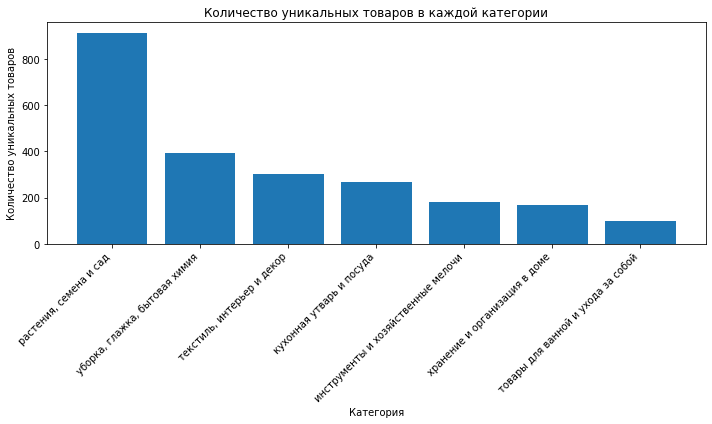

In [49]:
plt.figure(figsize=(10, 6))
plt.bar(category_counts['category'], category_counts['product'])
plt.title('Количество уникальных товаров в каждой категории')
plt.xlabel('Категория')
plt.ylabel('Количество уникальных товаров')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

In [50]:
# изучаю выручку по категориям
category_revenue = data.groupby('category')['total_cost'].sum().reset_index()
category_revenue = category_revenue.sort_values(by='total_cost', ascending = False)
display(category_revenue)

,category,total_cost
5,"уборка, глажка, бытовая химия",998474.666667
0,инструменты и хозяйственные мелочи,984425.583333
2,"растения, семена и сад",553456.333333
3,"текстиль, интерьер и декор",541688.833333
6,хранение и организация в доме,378508.000000
1,кухонная утварь и посуда,276976.000000
4,товары для ванной и ухода за собой,175724.000000


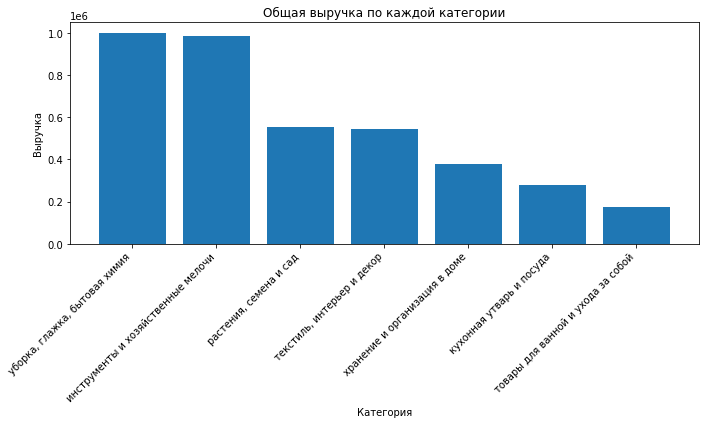

In [51]:
plt.figure(figsize=(10, 6))
plt.bar(category_revenue['category'], category_revenue['total_cost'])
plt.title('Общая выручка по каждой категории')
plt.xlabel('Категория')
plt.ylabel('Выручка')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

Категория «Растения, семена и сад» имеет самое большое количество уникальных наименований (913 товаров), что говорит о широте ассортимента, однако по выручке она занимает лишь третье место. Это может указывать на более низкую среднюю цену товаров или слабую конверсию продаж. Лидерами по выручке стали «Уборка, глажка, бытовая химия» и «Инструменты и хозяйственные мелочи», несмотря на значительно меньший ассортимент, что свидетельствует о высокой покупательской активности в этих категориях. Категория «Товары для ванной и ухода за собой» стабильно замыкает рейтинг как по количеству товаров, так и по объёму продаж.

In [52]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5500 entries, 0 to 7473
Data columns (total 10 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   date         5500 non-null   datetime64[ns]
 1   customer_id  5500 non-null   object        
 2   order_id     5500 non-null   object        
 3   product      5500 non-null   object        
 4   quantity     5500 non-null   int64         
 5   price        5500 non-null   float64       
 6   total_cost   5500 non-null   float64       
 7   month        5500 non-null   object        
 8   season       5500 non-null   object        
 9   category     5500 non-null   object        
dtypes: datetime64[ns](1), float64(2), int64(1), object(6)
memory usage: 472.7+ KB


#### Предварительный итог 1

В исходном датасете содержалось 7474 строк и 6 столбцов. На этапе предобработки данные были очищены и приведены к единому формату.

Тип данных в столбце date был преобразован в формат datetime, а в столбце order_id — из int64 в object, так как идентификаторы заказов не предназначены для арифметических операций. 

В датасете не оказалось пропущенных значений и полных дубликатов. Но были найдены и удалены частичные дубликаты: строки, где совпадали все значения, кроме даты, — в этих дубликатах сохранена только первая запись. Также исключено 109 строк, в которых совпадали наименование товара и номер заказа, но различалось количество — определить корректное значение в таком случае не представлялось возможным.

Столбцы quantity и price были проверены на наличие отрицательных или нецелых чисел — таких значений не обнаружено. Далее добавлен новый столбец total_cost, рассчитанный как произведение price на quantity.

Из датасета удалён выброс — заказ с аномально большим количеством (1000 единиц товара «вантуз»), сделанный единственным клиентом (для этого клиента это также единственный заказ).

На основе даты были добавлены новые столбцы month (месяц) и season (сезон).

Значения в столбце product были приведены к нижнему регистру для унификации. С помощью словаря все товары из столбца product были распределены по семи тематическим категориям, после чего добавлен столбец category с указанием этих категорий.

После выполнения всех этапов очистки и трансформации итоговый датасет содержит 5500 строк и 10 столбцов, полностью готов к дальнейшему анализу.

[Назад к оглавлению](#оглавление)

<a id='исследовательский-анализ-данных-eda'></a>

<a id='исследовательский-анализ-данных-eda'></a>
## Исследовательский анализ данных (EDA)

### Динамика ключевых показателей во времени

In [53]:
# проверяю временной интервал в нашем датасете - когда была самая первая и самая последняя покупки
data['date'].min(), data['date'].max()

(Timestamp('2018-10-01 00:00:00'), Timestamp('2020-01-31 15:00:00'))

In [54]:
# создаю отдельную таблицу с ключевыми показателями, агрегированными по месяцу+году
pivot = pd.pivot_table(
    data,
    index=data['date'].dt.to_period('M'),      # группирую по месяцу и году
    values=['order_id', 'total_cost', 'customer_id'],
    aggfunc={'order_id': pd.Series.nunique,     # количество уникальных заказов
             'total_cost': 'sum',               # выручка
             'customer_id': pd.Series.nunique}  # уникальные клиенты
)

pivot.rename(columns={'order_id': 'unique_orders', 'total_cost': 'revenue', 'customer_id': 'unique_customers'}, inplace=True)

# добавляю столбец со средним чеком
pivot['avg_check'] = pivot['revenue'] / pivot['unique_orders']

pivot = pivot.reset_index()

In [55]:
display(pivot.round(1))

,date,unique_customers,unique_orders,revenue,avg_check
0,2018-10,179,238,351162.0,1475.5
1,2018-11,178,204,359348.0,1761.5
2,2018-12,228,278,346744.0,1247.3
3,2019-01,147,163,229941.0,1410.7
4,2019-02,243,285,304705.0,1069.1
5,2019-03,225,240,248297.0,1034.6
6,2019-04,234,263,314670.0,1196.5
7,2019-05,161,175,231372.0,1322.1
8,2019-06,147,156,225116.0,1443.1
9,2019-07,186,197,234693.0,1191.3


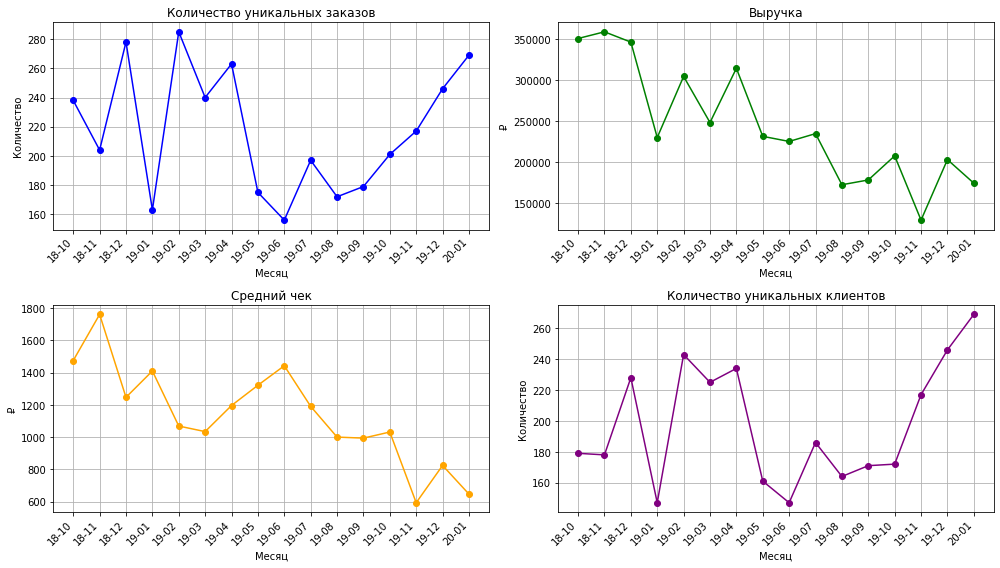

In [56]:
fig, axes = plt.subplots(2, 2, figsize=(14, 8))
axes = axes.flatten()

# динамика количества заказов
axes[0].plot(pivot['date'].dt.strftime('%y-%m'), pivot['unique_orders'], marker='o', color='blue')
axes[0].set_title('Количество уникальных заказов')
axes[0].set_xlabel('Месяц')
axes[0].set_ylabel('Количество')
axes[0].grid(True)

# динамика выручки
axes[1].plot(pivot['date'].dt.strftime('%y-%m'), pivot['revenue'], marker='o', color='green')
axes[1].set_title('Выручка')
axes[1].set_xlabel('Месяц')
axes[1].set_ylabel('₽')
axes[1].grid(True)

# динамика среднего чека
axes[2].plot(pivot['date'].dt.strftime('%y-%m'), pivot['avg_check'], marker='o', color='orange')
axes[2].set_title('Средний чек')
axes[2].set_xlabel('Месяц')
axes[2].set_ylabel('₽')
axes[2].grid(True)

# динамика уникальных клиентов
axes[3].plot(pivot['date'].dt.strftime('%y-%m'), pivot['unique_customers'], marker='o', color='purple')
axes[3].set_title('Количество уникальных клиентов')
axes[3].set_xlabel('Месяц')
axes[3].set_ylabel('Количество')
axes[3].grid(True)

for ax in axes:
    for label in ax.get_xticklabels():
        label.set_rotation(45)
        label.set_ha('right')
plt.tight_layout()
plt.xticks(rotation=45)
plt.show()

Первое, что бросается в глаза - выручка магазина постепенно снижалась с апреля 2019 года, достигнув минимального значения в ноябре 2019-го. Незначительный рост наблюдался только в июле и октябре, но он не компенсировал общую нисходящую тенденцию. В декабре 2019 года выручка выросла (возможно, за счёт предновогоднего спроса), однако уже в январе 2020 года снова снизилась.  
Интересно, что количество уникальных клиентов и заказов за тот же период, напротив, демонстрировало умеренный, но стабильный рост. Это может означать, что аудитория расширялась, но каждый клиент совершал покупки меньшего объёма или меньшей стоимости. Это подтверждает и динамика среднего чека: он начал снижаться с июня 2019 года, достигнув минимума в ноябре 2019-го. После кратковременного увеличения в декабре, он снова упал в январе 2020-го. Вероятно, клиенты стали отдавать предпочтение более дешёвым или мелким товарам, что согласуется со снижением выручки при росте числа заказов.

### Анализ продаж по товарам и категориям

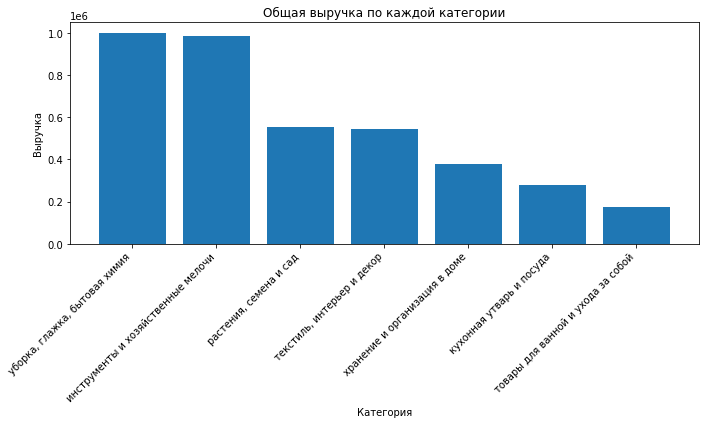

In [57]:
# еще раз оценим выручку по категориям 

plt.figure(figsize=(10, 6))
plt.bar(category_revenue['category'], category_revenue['total_cost'])
plt.title('Общая выручка по каждой категории')
plt.xlabel('Категория')
plt.ylabel('Выручка')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

In [58]:
# изучу, какую выручку в среднем приносит ОДИН заказ в каждой категории
avg_revenue_per_order = (
    data.groupby('category')['total_cost']
    .mean()
    .sort_values(ascending=False)
)
print(avg_revenue_per_order)

category
инструменты и хозяйственные мелочи    2004.940088
хранение и организация в доме         1332.774648
уборка, глажка, бытовая химия         1213.213447
товары для ванной и ухода за собой     998.431818
текстиль, интерьер и декор             922.808915
кухонная утварь и посуда               682.206897
растения, семена и сад                 202.508721
Name: total_cost, dtype: float64


Как я уже писала выше, наибольшую выручку приносят категории «уборка, глажка, бытовая химия» и «инструменты и хозяйственные мелочи», что может отражать стабильный бытовой спрос и относительно высокие цены на такие товары. При этом категория «растения, семена и сад», хоть и входит в топ-3 по объемам общей выручки, все же значительно уступает первым двум категориям, а также демонстрирует самый низкий средний чек, что указывает, как и предполагалось ранее, на недорогие единичные покупки, вероятно, сезонного характера. Поскольку категории сформированы вручную, при иной логике группировки структура выручки и средних чеков может измениться.

In [59]:
# изучаю топ-10 наиболее продаваемых товаров по всему датасету
popular_products = (
    data.groupby('product')['quantity']
    .sum()
    .sort_values(ascending=False)
)
display(popular_products.head(10))

product
муляж яблоко 9 см красное                                                         618
вешалки мягкие для деликатных вещей 3 шт шоколад                                  335
ручка-скоба рс-100 белая *трибатрон*, 1108035                                     201
крепеж для пружины дверной, 1107055                                               170
плечики пластмассовые размер 52 - 54 тула 1205158                                 160
пружина дверная 240 мм оцинкованная (д-19 мм) без крепления, 1107014              150
муляж яблоко зеленый 9 см полиуретан                                              148
муляж банан желтый 21 см полиуретан                                               109
щетка-сметка 4-х рядная деревянная 300 мм (фигурная ручка) ворс 5,5 см 1801096    105
ёрш унитазный с деревянной ручкой , ваир 1712012                                  103
Name: quantity, dtype: int64

Наиболее популярными товарами оказались муляжи фруктов и предметы для дома (вешалки, дверные пружины, щётки), что может указывать на высокий спрос на недорогие и практичные позиции.  
Перед тем, как анализировать наименее продаваемые товары, изучу, какое в целом количество товаров из всего ассортимента продавалось в количестве 1 единицы за весь рассматриваемый период.

In [60]:
# группирую по товару и считаю общее количество проданных единиц
product_sales = data.groupby('product')['quantity'].sum()

# оставляю только те товары, у которых общее количество = 1
single_item_products = product_sales[product_sales == 1]

# проверяю количество таких товаров
len(single_item_products)

896

In [61]:
# считаю, какую долю от общего ассортимента составляют эти товары
product_sales[product_sales == 1].sum()/product_sales.sum()*100

6.800242865816636

Анализ показал, что 896 товаров (около 7% от общего ассортимента) были проданы лишь один раз за весь рассматриваемый период. В связи с этим выделение топ-10 наименее продаваемых товаров не имеет аналитического смысла, так как таких позиций слишком много и их продажи единичны.  
А вот наиболее продаваемые товары проанализирую еще и в разрезе категорий.

In [62]:
top5_popular = (
    data.groupby(['category', 'product'], as_index=False)['quantity']
    .sum()
    .sort_values(['category', 'quantity'], ascending=[True, False])
    .groupby('category')
    .head(5)
)
display(top5_popular)

,category,product,quantity
31,инструменты и хозяйственные мелочи,"ручка-скоба рс-100 белая *трибатрон*, 1108035",201
4,инструменты и хозяйственные мелочи,"крепеж для пружины дверной, 1107055",170
61,инструменты и хозяйственные мелочи,"стяжка оконная с болтом ст-55 цинк, 1108354",101
3,инструменты и хозяйственные мелочи,"крепеж для пружины дверной оцинкованный, 1107054",100
180,инструменты и хозяйственные мелочи,"шпингалет 80 мм белый с пружиной, 1102188",100
413,кухонная утварь и посуда,универсальный нож webber из нержавеющей стали ...,81
214,кухонная утварь и посуда,"ковш пластмассовый полимербыт с215, 1,5 л 1406006",69
268,кухонная утварь и посуда,набор ножей attribute chef 5 предметов akf522,64
234,кухонная утварь и посуда,кружка с трубочкой attribute мяч 500 мл jar501,61
388,кухонная утварь и посуда,"тарелка суповая luminarc океан эклипс 20,5 см ...",60


Среди всех категорий наибольшие объёмы продаж сосредоточены в разделе «инструменты и хозяйственные мелочи», где лидеры значительно опережают другие товары по количеству проданных единиц.  
В то же время в категориях вроде «текстиль, интерьер и декор» и «хранение и организация в доме» отдельные позиции (например, муляжи фруктов и вешалки) также демонстрируют устойчивый спрос, что может указывать на их популярность как недорогих, но часто покупаемых товаров.  

Перейду к анализу по выручке среди товаров. Для него я отберу только те товары, которые были куплены более чем один раз. Это позволит исключить случайные или разовые покупки, особенно среди дорогих товаров, и сосредоточиться на позициях с регулярным спросом и устойчивым вкладом в выручку.

In [63]:
multi_sales = data[data['quantity'] > 1]

revenue_by_product = (
    multi_sales
    .groupby(['category', 'product'], as_index=False)
    .agg({'total_cost': 'sum', 'quantity': 'sum'})
    .sort_values('total_cost', ascending=False)
)

revenue_by_product.head(10)

,category,product,total_cost,quantity
547,"текстиль, интерьер и декор",простынь вафельная 200х180 см wellness rw180-0...,53232.0,30
739,хранение и организация в доме,вешалки мягкие для деликатных вещей 3 шт шоколад,49432.0,334
23,инструменты и хозяйственные мелочи,тележка багажная delta тбр-22 синий грузоподъе...,32718.0,57
531,"текстиль, интерьер и декор",муляж яблоко 9 см красное,32643.0,617
67,кухонная утварь и посуда,набор ножей attribute chef 5 предметов akf522,29248.0,64
776,хранение и организация в доме,"урна уличная ""гео"", hobbyka/хоббика, 59*37,5см...",24370.0,5
616,"уборка, глажка, бытовая химия","веник сорго с деревянной ручкой с 4-мя швами, ...",20010.0,37
626,"уборка, глажка, бытовая химия",мусорный контейнер hailo bigbin swing 45 0845-...,16536.0,3
480,"текстиль, интерьер и декор",коврик придверный attribute nature кокосовый 6...,16506.0,53
552,"текстиль, интерьер и декор",салфетка protec textil polyline 30х43 см амети...,15700.0,80


Среди товаров, купленных более чем в одном экземпляре, наибольшую выручку приносят простыни, мягкие вешалки и багажные тележки. При этом неожиданно высокие позиции муляжей яблок и салфеток показывают, что даже недорогие декоративные и повседневные товары могут обеспечивать значительный оборот за счёт массового спроса. Это подчёркивает важность регулярных, повторяющихся покупок в формировании общей выручки.

### Создание агрегированной по клиентам таблицы

In [64]:
# агрегирую данные по customer_id
customers = data.groupby('customer_id').agg({
    'total_cost': 'sum',         # общая выручка от покупателя
    'order_id': 'nunique',       # количество уникальных заказов
    'date': 'max'                # дата последнего заказа
}).reset_index()

In [65]:
# переименовываю колонки для удобства
customers.rename(columns={
    'total_cost': 'revenue',
    'order_id': 'order_quantity',
    'date': 'latest_order'
}, inplace=True)

In [66]:
# нахожу самую последнюю дату покупки в датасете
latest_date = data['date'].max()

# добавляю колонку с этой датой и считаю recency
customers['latest_date'] = latest_date
customers['recency'] = (customers['latest_date'] - customers['latest_order']).dt.days

In [67]:
# проверяю данные
customers.sample(5)

,customer_id,revenue,order_quantity,latest_order,latest_date,recency
2339,f93a07fa-9ccc-434a-b4ae-8481c0c2ddfa,4900.0,1,2019-02-28 13:00:00,2020-01-31 15:00:00,337
1565,aad8e182-8789-4c16-a85e-5750edd1099f,299.0,1,2018-10-23 21:00:00,2020-01-31 15:00:00,464
312,221bc556-0465-4953-8788-01055145c66d,1087.0,1,2019-05-26 13:00:00,2020-01-31 15:00:00,250
2395,ff0c73c3-6b62-4e67-8e12-bb83ed1851d5,899.0,1,2019-10-30 19:00:00,2020-01-31 15:00:00,92
1136,7abce1cc-bc8c-4362-b61a-0cbb4822ed29,7950.0,2,2019-10-03 13:00:00,2020-01-31 15:00:00,120


### Анализ динамики клиентских метрик

In [68]:
# агрегирую исходные данные по месяцам и клиентам
monthly_customers = data.groupby(['month', 'customer_id']).agg({
    'total_cost': 'sum',       # сумма покупок клиента за месяц
    'order_id': 'nunique'      # количество заказов клиента за месяц
}).reset_index()

In [69]:
# считаю средние значения ключевых метрик по месяцам
monthly_metrics = monthly_customers.groupby('month').agg({
    'order_id': 'mean',        # средняя частота покупок одним клиентом
    'total_cost': 'mean'       # средняя выручка на одного клиента
}).reset_index()

In [70]:
monthly_metrics.rename(columns={
    'total_cost': 'avg_revenue',
    'order_id': 'avg_order_quantity'
}, inplace=True)

In [71]:
# добавляю столбец со средним чеком
monthly_metrics['avg_check'] = monthly_metrics['avg_revenue'] / monthly_metrics['avg_order_quantity']

print(monthly_metrics.round(2))

      month  avg_order_quantity  avg_revenue  avg_check
0   2018-10                1.33      1961.80    1475.47
1   2018-11                1.15      2018.81    1761.51
2   2018-12                1.22      1520.81    1247.28
3   2019-01                1.11      1564.22    1410.68
4   2019-02                1.17      1253.93    1069.14
5   2019-03                1.07      1103.54    1034.57
6   2019-04                1.12      1344.74    1196.46
7   2019-05                1.09      1437.09    1322.13
8   2019-06                1.06      1531.40    1443.05
9   2019-07                1.06      1261.79    1191.34
10  2019-08                1.05      1049.39    1000.58
11  2019-09                1.05      1040.65     994.14
12  2019-10                1.17      1206.05    1032.04
13  2019-11                1.00       593.51     593.51
14  2019-12                1.00       824.74     824.74
15  2020-01                1.00       646.98     646.98


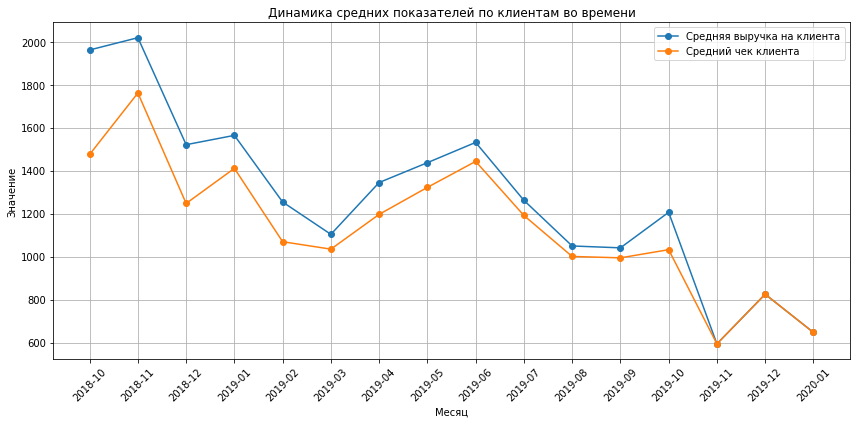

In [72]:
# строю визуализацию динамики средних показателей во времени

plt.figure(figsize=(12, 6))

plt.plot(monthly_metrics['month'], monthly_metrics['avg_revenue'], marker='o', label='Средняя выручка на клиента')
plt.plot(monthly_metrics['month'], monthly_metrics['avg_check'], marker='o', label='Средний чек клиента')

plt.title('Динамика средних показателей по клиентам во времени')
plt.xlabel('Месяц')
plt.ylabel('Значение')
plt.xticks(rotation=45)
plt.legend()
plt.grid(True)
plt.tight_layout()

plt.show()

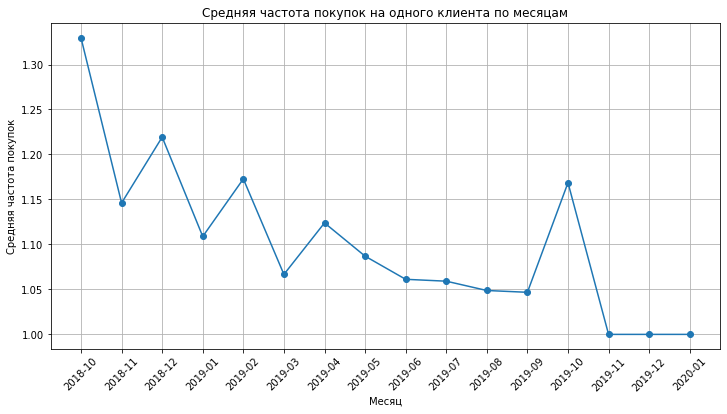

In [73]:
# так как у этого параметра другой разброс значений по оси Y, отдельно визуализирую динамику средней частоты покупок на клиента по месяцам
plt.figure(figsize=(12, 6))
plt.plot(monthly_metrics['month'], monthly_metrics['avg_order_quantity'], marker='o')
plt.title('Средняя частота покупок на одного клиента по месяцам')
plt.xlabel('Месяц')
plt.ylabel('Средняя частота покупок')
plt.xticks(rotation=45)
plt.grid(True)
plt.show()

Судя по данным, активность клиентов постепенно снижалась с конца 2018 по 2020 год. В октябре–ноябре 2018 наблюдались самые высокие показатели по среднему чеку и выручке (при том, что среднее количество заказов на клиента показывает не самые высокие значения), после чего началось устойчивое падение почти по всем метрикам. Среднее количество заказов на клиента стабильно держится чуть выше 1, но ближе к концу периода падает до 1.00 — клиенты фактически делают один заказ в месяц. Это может указывать на снижение лояльности и интереса покупателей, а также возможные проблемы с удержанием клиентов.

### Анализ распределения заказов по клиентам

In [74]:
# считаю количество заказов на клиента
orders_per_customer = data.groupby('customer_id')['order_id'].nunique().reset_index()
orders_per_customer.columns = ['customer_id', 'order_count']

In [75]:
# создаю категории по количеству заказов
def categorize_orders(x):
    if x == 1:
        return '1 заказ'
    elif 2 <= x <= 3:
        return '2–3 заказа'
    elif 4 <= x <= 5:
        return '4–5 заказов'
    else:
        return '5+ заказов'

orders_per_customer['order_group'] = orders_per_customer['order_count'].apply(categorize_orders)

In [76]:
# считаю количество клиентов в каждой группе и их долю
order_distribution = (
    orders_per_customer['order_group']
    .value_counts(normalize=False)
    .reset_index()
    .rename(columns={'index': 'order_group', 'order_group': 'customer_count'})
)
order_distribution['share_%'] = round(order_distribution['customer_count'] / orders_per_customer.shape[0] * 100, 2)

In [77]:
display(order_distribution)

,order_group,customer_count,share_%
0,1 заказ,1531,63.71
1,2–3 заказа,864,35.96
2,4–5 заказов,4,0.17
3,5+ заказов,4,0.17


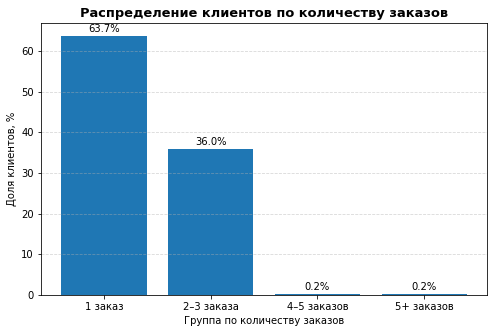

In [78]:
# сортируем группы, если нужно (например, по возрастанию количества заказов)
order_distribution = order_distribution.sort_values('order_group')

# строим bar chart
plt.figure(figsize=(8, 5))
bars = plt.bar(order_distribution['order_group'], order_distribution['share_%'])

# добавляем подписи процентов над столбцами
for bar, share in zip(bars, order_distribution['share_%']):
    plt.text(
        bar.get_x() + bar.get_width() / 2,
        bar.get_height() + 0.5,
        f'{share:.1f}%',
        ha='center',
        va='bottom',
        fontsize=10
    )

# оформление
plt.title('Распределение клиентов по количеству заказов', fontsize=13, fontweight='bold')
plt.xlabel('Группа по количеству заказов')
plt.ylabel('Доля клиентов, %')
plt.grid(axis='y', linestyle='--', alpha=0.5)

plt.show()

Большинство клиентов (63,7%) совершили только один заказ за весь рассматриваемый период, что указывает на низкий уровень повторных покупок и ограниченную лояльность аудитории. Почти 36% покупателей сделали 2–3 заказа, что можно считать умеренной вовлечённостью. При этом регулярные клиенты, совершающие 4 и более покупок, составляют лишь доли процента от всей базы. Такая структура клиентской активности говорит о необходимости удерживающих стратегий — например, персонализированных предложений или программ лояльности.

#### Предварительный итог 2

В ходе исследовательского анализа данных (EDA) были изучены ключевые метрики продаж, динамика клиентской активности и структура выручки по категориям товаров.

1. Общие тенденции

Первое, что бросается в глаза, — постепенное снижение выручки с апреля 2019 года, достигшее минимума в ноябре того же года. Небольшие всплески наблюдались в июле и октябре, однако они не компенсировали общую нисходящую тенденцию. В декабре выручка заметно выросла (вероятно, за счёт предновогоднего спроса), но уже в январе 2020 года снова упала.

Интересно, что при этом количество уникальных клиентов и заказов за тот же период, напротив, умеренно росло. Это говорит о расширении аудитории при снижении среднего объёма покупок на клиента. Средний чек демонстрирует ту же тенденцию: начиная с июня 2019 года, он стабильно снижался, достиг минимума осенью, затем кратковременно вырос в декабре и снова упал в январе. Таким образом, рост числа заказов сопровождался переходом клиентов к более мелким или дешевым покупкам.

2. Продажи по категориям товаров

Наибольшую выручку формируют категории «уборка, глажка, бытовая химия» и «инструменты и хозяйственные мелочи» — сегменты с устойчивым бытовым спросом и относительно высокими ценами.
Третье место занимает категория «растения, семена и сад», при этом она демонстрирует самый низкий средний чек. Это указывает на преобладание недорогих, единичных, вероятно сезонных покупок.

Стоит отметить, что категории были сгруппированы вручную, поэтому при иной логике классификации структура выручки и средних чеков может частично измениться.

3. Наиболее и наименее популярные товары

Самыми популярными позициями оказались муляжи фруктов и предметы для дома (вешалки, дверные пружины, щётки) — недорогие, функциональные товары с массовым спросом.
При этом 896 товаров (около 7% ассортимента) были проданы всего один раз за весь период. Поэтому выделение “антирейтинга” из 10 наименее популярных позиций не имеет аналитического смысла — их слишком много и объём продаж по ним единичен.

Среди товаров, купленных более одного раза, наибольший вклад в выручку вносят простыни, мягкие вешалки и багажные тележки. Высокие позиции у муляжей яблок и салфеток показывают, что даже недорогие товары могут обеспечивать значительный оборот при высокой частоте покупок — что подчёркивает роль повторных продаж в общей выручке.

4. Клиентская активность и лояльность

Для анализа клиентской базы была создана агрегированная таблица customers, включающая метрики recency, frequency и monetary.

Динамика клиентских показателей подтверждает снижение активности покупателей с конца 2018 по 2020 год:  
- Средний чек и средняя выручка на клиента достигли пика в октябре–ноябре 2018, после чего началось устойчивое падение.  
- Среднее количество заказов на клиента удерживалось чуть выше 1, но к концу периода снизилось почти до 1.0 — фактически один заказ на клиента в месяц.

Распределение количества заказов по клиентам показало низкий уровень удержания:  
- 63,7% клиентов совершили только один заказ за весь период;  
- около 36% — 2–3 заказа;  
- регулярные клиенты с 4+ заказами составляют лишь доли процента.  

Такая структура говорит о необходимости стратегий удержания — персонализированных предложений, акций на повторные заказы, или внедрения программы лояльности.

5. Общий вывод

Суммарно данные указывают на:

1) снижение выручки и среднего чека при росте количества клиентов — то есть на количественное расширение аудитории без качественного роста продаж;

2) низкий уровень удержания — большинство клиентов делают единовременные покупки;

3) сезонные всплески (особенно в декабре) и зависимость ряда категорий от сезонного спроса;

4) высокую долю массовых, недорогих товаров в структуре продаж, определяющую оборот компании.

На следующем этапе — RFM-сегментация и анализ сезонности внутри сегментов — позволит точнее понять поведение разных групп клиентов, определить, кто приносит основную выручку и в какие периоды их активность максимальна.

[Назад к оглавлению](#оглавление)

<a id='сегментация'></a>
## Сегментация покупателей

Для сегментации клиентской базы выбран RFM-анализ, поскольку он позволяет оценить ценность и лояльность покупателей на основе трех ключевых метрик:

Recency (R) — как давно клиент совершал последнюю покупку;

Frequency (F) — как часто он покупает;

Monetary (M) — какой доход приносит бизнесу.

Такой подход помогает выявить наиболее активных, прибыльных и перспективных клиентов, а также тех, кто утратил интерес и требует реактивации.

В качестве способа разбиения покупателей на группы выбран гибридный метод:

для метрик Recency и Monetary применено квантильное деление (по терцилям), что позволяет учесть реальное распределение данных и избежать смещения, вызванного разбросом значений;

для Frequency использовано пороговое деление — выделены клиенты с одной покупкой и с двумя и более покупками.
Такое решение связано с тем, что подавляющая часть клиентов (около 64%) совершили только одну покупку, а доля покупателей с четырьмя и более заказами статистически незначительна, что делает квантильное деление по этой метрике неинформативным.

Таким образом, выбранная схема сегментации обеспечивает баланс между статистической устойчивостью и практической интерпретируемостью результатов.

In [79]:
# квантильное деление для Recency и Monetary
customers['R_score'] = pd.qcut(customers['recency'], q=3, labels=[3, 2, 1])  # чем меньше recency, тем лучше
customers['M_score'] = pd.qcut(customers['revenue'], q=3, labels=[1, 2, 3])

# простое пороговое деление для Frequency
customers['F_score'] = customers['order_quantity'].apply(lambda x: 1 if x == 1 else 2)

# считаю итоговый RFM score
customers['RFM_score'] = customers['R_score'].astype(int) + customers['F_score'].astype(int) + customers['M_score'].astype(int)

In [80]:
customers['RFM_score'].unique()

array([5, 3, 6, 8, 4, 7])

Как я писала выше, RFM-анализ оценивает клиентов по трём ключевым параметрам — давность последней покупки (Recency), частота покупок (Frequency) и денежный вклад (Monetary). Каждому клиенту присваиваются оценки от 1 до 3 по параметрам Recency и Monetary и от 1 до 2 по параметру Frequency, после чего формируется общий балл (RFM_score), варьирующийся от 3 до 8. Чем выше итоговый балл, тем выше ценность клиента для бизнеса.  
Так как в нашем случае шкала имеет всего 6 возможных значений (3–8), я выбираю разбивку клиентов на 3 сегмента, отражающих естественные поведенческие различия клиентов:

3–4 балла — клиенты с низкими значениями хотя бы по двум параметрам: покупают редко, давно и приносят малую выручку → «Потерянные» или неактивные клиенты.

5–6 баллов — средние значения по всем параметрам: совершают заказы, но без стабильности → «Перспективные» клиенты, которых можно активировать маркетингом.

7–8 баллов — высокие значения по всем параметрам: недавние, частые и прибыльные покупки → «Лояльные» или ключевые клиенты.

In [81]:
def segment_rfm(score):
    if score <= 4:
        return 'Потерянные клиенты'
    elif 5 <= score <= 6:
        return 'Перспективные клиенты'
    else:
        return 'Лояльные / ключевые клиенты'

customers['segment'] = customers['RFM_score'].apply(segment_rfm)

In [82]:
customers.sample(10)

,customer_id,revenue,order_quantity,latest_order,latest_date,recency,R_score,M_score,F_score,RFM_score,segment
1447,9c59ebc7-39e2-49f8-b817-4113824522f8,852.0,1,2019-04-07 14:00:00,2020-01-31 15:00:00,299,2,2,1,5,Перспективные клиенты
1277,8a2f2c40-48a4-4e6c-8a65-64e692ad1b2a,1500.0,1,2019-10-11 06:00:00,2020-01-31 15:00:00,112,2,3,1,6,Перспективные клиенты
1403,97c2abe8-fadb-4a67-84b8-b7540f095ced,2376.0,2,2019-12-22 14:00:00,2020-01-31 15:00:00,40,3,3,2,8,Лояльные / ключевые клиенты
1472,9ecc5887-b4d4-4cea-b446-88748df71d9c,1799.0,1,2020-01-04 16:00:00,2020-01-31 15:00:00,26,3,3,1,7,Лояльные / ключевые клиенты
2255,f1222eaa-d09d-4bff-ab4e-bea6fe3f68a8,3374.0,1,2020-01-05 20:00:00,2020-01-31 15:00:00,25,3,3,1,7,Лояльные / ключевые клиенты
632,4396f810-bf7a-4044-8919-837a05dd0853,553.0,2,2020-01-09 17:00:00,2020-01-31 15:00:00,21,3,2,2,7,Лояльные / ключевые клиенты
2310,f5b06482-7a1f-4363-b8d3-083eed6c7ce5,172.0,1,2018-12-20 15:00:00,2020-01-31 15:00:00,407,1,1,1,3,Потерянные клиенты
749,50a22631-67a8-4fdc-86d6-1e779617fdf8,367.0,2,2019-11-13 15:00:00,2020-01-31 15:00:00,79,3,1,2,6,Перспективные клиенты
2321,f6f64601-5375-4ada-ab77-2ff0acdebbff,1836.0,2,2020-01-12 14:00:00,2020-01-31 15:00:00,19,3,3,2,8,Лояльные / ключевые клиенты
613,412563c4-ef06-4617-8e87-588a75b169dc,1424.0,1,2019-09-29 20:00:00,2020-01-31 15:00:00,123,2,3,1,6,Перспективные клиенты


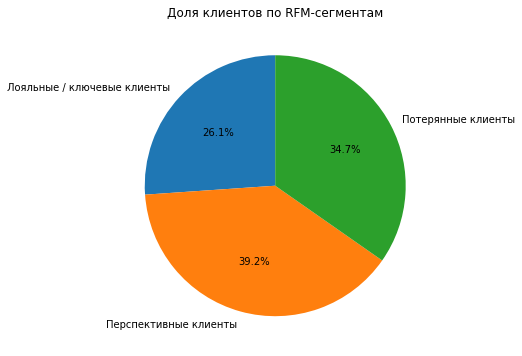

In [83]:
# визуализирую долю клиентов по сегментам
segment_counts = customers['segment'].value_counts(normalize=True).sort_index()*100

plt.figure(figsize=(6, 6))
plt.pie(segment_counts, labels=segment_counts.index, autopct='%1.1f%%', startangle=90)
plt.title('Доля клиентов по RFM-сегментам')
plt.show()

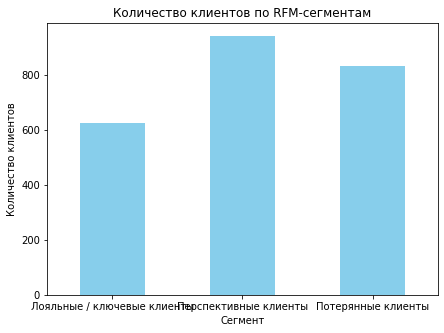

In [84]:
segment_counts = customers['segment'].value_counts().sort_index()

plt.figure(figsize=(7, 5))
segment_counts.plot(kind='bar', color='skyblue')
plt.title('Количество клиентов по RFM-сегментам')
plt.xlabel('Сегмент')
plt.ylabel('Количество клиентов')
plt.xticks(rotation=0)
plt.show()


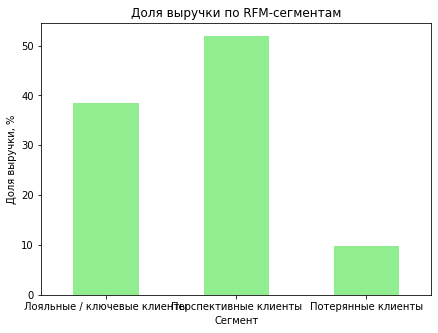

In [85]:
# визуализирую долю выручки по сегментам
revenue_share = customers.groupby('segment')['revenue'].sum().sort_index()
revenue_share_percent = (revenue_share / revenue_share.sum()) * 100

plt.figure(figsize=(7, 5))
revenue_share_percent.plot(kind='bar', color='lightgreen')
plt.title('Доля выручки по RFM-сегментам')
plt.xlabel('Сегмент')
plt.ylabel('Доля выручки, %')
plt.xticks(rotation=0)
plt.show()

In [86]:
segment_summary = customers.groupby('segment').agg({
    'revenue': 'mean',
    'order_quantity': 'mean',
    'recency': 'mean'
}).reset_index()

segment_summary = segment_summary.rename(columns={'revenue': 'avg_check', 'order_quantity': 'avg_order_quantity'})

display(segment_summary.round(2))

,segment,avg_check,avg_order_quantity,recency
0,Лояльные / ключевые клиенты,2392.97,2.03,59.13
1,Перспективные клиенты,2154.80,1.44,223.55
2,Потерянные клиенты,454.49,1.02,321.84


#### Предварительный итог 3

Для базового уровня анализа выделенные RFM-сегменты уже достаточно чётко отражают различия в поведении клиентов. Анализ средних значений подтверждает эти различия: «лояльные / ключевые клиенты» совершают в среднем около 2 покупок и приносят наибольшую выручку (≈2390 р. на клиента) при минимальной давности последней покупки (≈59 дней). «Перспективные клиенты» делают около 1,4 заказа на ≈2150 р., однако реже возвращаются (≈224 дня с последнего заказа), что указывает на риск потери при отсутствии стимулирования повторных покупок. «Потерянные клиенты» совершают лишь 1 заказ на ≈450 р., и средний интервал с момента последней покупки (≈320 дней) подтверждает их низкую вовлечённость.

Дополнительное деление сегментов на подкатегории пока не требуется, поскольку текущая модель уже даёт чёткое понимание клиентской структуры: «потерянные» составляют около 35% аудитории, но приносят менее 10% выручки, тогда как «перспективные» обеспечивают более половины дохода. При дальнейшем расширении базы данных или планировании точечных маркетинговых действий возможна более детальная сегментация — например, по давности или частоте покупок.

[Назад к оглавлению](#оглавление)

<a id='проверка-гипотез'></a>
## Проверка гипотез

Гипотезы, которые я буду проверять на данном этапе:

**Гипотеза 1. Средний чек.**  
  H0: Средний чек клиентов не отличается между сегментами.  
  H1: Средний чек клиентов отличается хотя бы в одном сегменте.  
  **Гипотеза 2. Частота покупок.**  
  H0: Среднее количество покупок клиентов не отличается между сегментами.  
  H1: Среднее количество покупок клиентов отличается хотя бы в одном сегменте.  

In [87]:
# добавляю столбец с показателями среднего чека
customers['avg_check'] = customers['revenue'] / customers['order_quantity']

Сегмент: Перспективные клиенты | Средний чек | p-value: 0.00000
Сегмент: Перспективные клиенты | Количество заказов | p-value: 0.00000

Сегмент: Потерянные клиенты | Средний чек | p-value: 0.00000
Сегмент: Потерянные клиенты | Количество заказов | p-value: 0.00000

Сегмент: Лояльные / ключевые клиенты | Средний чек | p-value: 0.00000
Сегмент: Лояльные / ключевые клиенты | Количество заказов | p-value: 0.00000



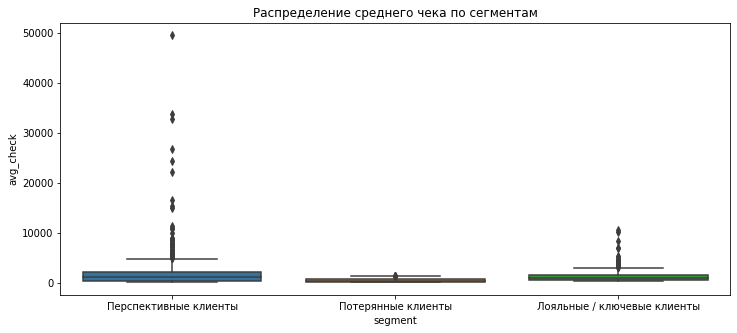

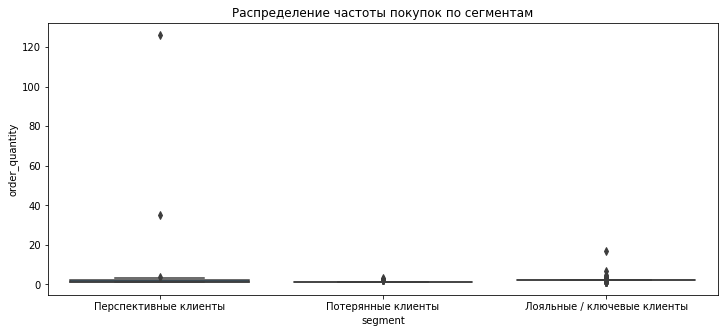

In [88]:
# проверка нормальности распределения по каждому сегменту с помощью теста Шапиро-Уилка
for segment in customers['segment'].unique():
    seg_data_check = customers.loc[customers['segment'] == segment, 'avg_check']
    stat, p = shapiro(seg_data_check)
    print(f'Сегмент: {segment} | Средний чек | p-value: {p:.5f}')

    seg_data_freq = customers.loc[customers['segment'] == segment, 'order_quantity']
    stat, p = shapiro(seg_data_freq)
    print(f'Сегмент: {segment} | Количество заказов | p-value: {p:.5f}\n')

# визуализация распределений
plt.figure(figsize=(12, 5))
sns.boxplot(x='segment', y='avg_check', data=customers)
plt.title('Распределение среднего чека по сегментам')
plt.show()

plt.figure(figsize=(12, 5))
sns.boxplot(x='segment', y='order_quantity', data=customers)
plt.title('Распределение частоты покупок по сегментам')
plt.show()

In [89]:
# Краскел-Уоллис для среднего чека
groups_check = [group["avg_check"].values for name, group in customers.groupby("segment")]
stat, p = kruskal(*groups_check)
print(f'Краскел-Уоллис для среднего чека: p-value = {p:.4f}')

# Краскел-Уоллис для количества заказов
groups_freq = [group["order_quantity"].values for name, group in customers.groupby("segment")]
stat, p = kruskal(*groups_freq)
print(f'Краскел-Уоллис для количества заказов: p-value = {p:.4f}')

Краскел-Уоллис для среднего чека: p-value = 0.0000
Краскел-Уоллис для количества заказов: p-value = 0.0000


Для проверки гипотез использовались тесты Шапиро–Уилка и Краскела–Уоллиса.  
Распределение данных оказалось ненормальным, поэтому был выбран непараметрический тест.

#### Предварительный итог 4

**Результаты проверки гипотез**

Для оценки различий между группами был проведён критерий Краскела–Уоллиса по двум показателям:

Средний чек: p-value = 0.0000

Количество заказов: p-value = 0.0000

Так как во всех случаях p-value < 0.05, нулевая гипотеза об отсутствии различий между группами отвергается с высокой степенью уверенности.
Это означает, что различия в среднем чеке и количестве заказов между группами статистически значимы, и их нельзя объяснить случайными колебаниями данных.

**Интерпретация результатов**

Полученные результаты указывают на то, что поведение пользователей (или клиентов) в разных группах существенно различается — как по уровню среднего чека, так и по интенсивности покупок (числу заказов).
Другими словами, сегментация оказалась обоснованной с точки зрения статистики: группы действительно отличаются по ключевым метрикам, что подтверждает корректность их выделения и возможность дальнейшего анализа различий между ними (например, в рамках пост-хок тестов или анализа профилей клиентов).

[Назад к оглавлению](#оглавление)

<a id='анализ_сезонности'></a>
## Анализ покупок и сезонности внутри сегментов

In [90]:
# агрегирую данные для анализа сезонности
seasonality = (
    data.merge(customers[['customer_id', 'segment']], on='customer_id', how='left')
    .groupby(['customer_id', 'segment', 'category', 'month', 'season'], as_index=False)
    .agg({
        'order_id': 'nunique',      # количество заказов
        'quantity': 'sum',          # количество купленных товаров
        'total_cost': 'sum'         # общая выручка
    })
    .rename(columns={
        'order_id': 'order_count',
        'quantity': 'total_quantity',
        'total_cost': 'revenue'
    })
)
display(seasonality)

,customer_id,segment,category,month,season,order_count,total_quantity,revenue
0,000d6849-084e-4d9f-ac03-37174eaf60c4,Перспективные клиенты,"растения, семена и сад",2019-10,4_осень,1,4,555.0
1,001cee7f-0b29-4716-b202-0042213ab038,Потерянные клиенты,"уборка, глажка, бытовая химия",2019-02,1_зима,1,1,442.0
2,00299f34-5385-4d13-9aea-c80b81658e1b,Перспективные клиенты,"уборка, глажка, бытовая химия",2019-10,4_осень,1,2,914.0
3,002d4d3a-4a59-406b-86ec-c3314357e498,Перспективные клиенты,инструменты и хозяйственные мелочи,2019-01,1_зима,1,1,1649.0
4,003bbd39-0000-41ff-b7f9-2ddaec152037,Перспективные клиенты,хранение и организация в доме,2019-09,4_осень,1,2,2324.0
...,...,...,...,...,...,...,...,...
3279,ff601403-b094-4b86-9ac6-264d725b9277,Лояльные / ключевые клиенты,"растения, семена и сад",2020-01,1_зима,1,1,90.0
3280,ffaeab76-3a8d-49ee-860f-17273b2fc8a2,Перспективные клиенты,"уборка, глажка, бытовая химия",2019-10,4_осень,1,1,397.0
3281,ffb5976a-7a4d-460b-95c4-5ffaba31cb24,Потерянные клиенты,"текстиль, интерьер и декор",2018-12,1_зима,1,1,389.0
3282,ffb80538-3fda-4351-8ea9-9d2bec58bb07,Перспективные клиенты,кухонная утварь и посуда,2019-09,4_осень,1,1,974.0


In [91]:
# агрегирую выручку по сегментам и месяцам
segment_monthly_revenue = (
    seasonality.groupby(['segment', 'month'], as_index=False)['revenue']
    .sum()
    .sort_values('month')
)

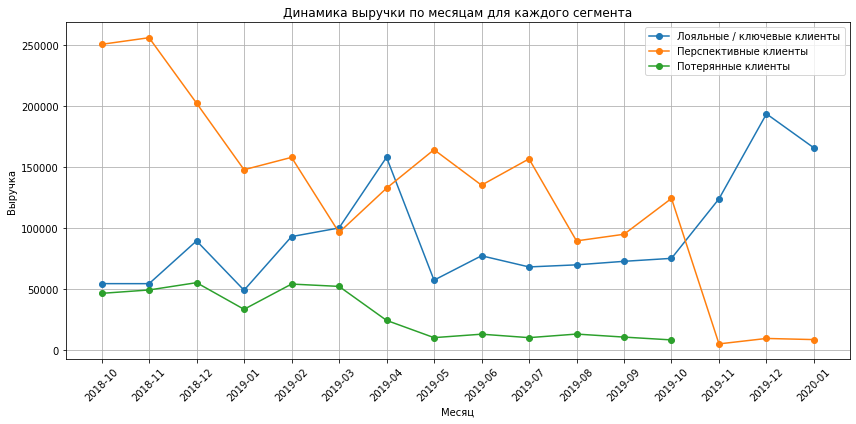

In [92]:
# визуализирую динамику выручки по месяцам для каждого сегмента
plt.figure(figsize=(12, 6))
for segment in segment_monthly_revenue['segment'].unique():
    segment_data = segment_monthly_revenue[segment_monthly_revenue['segment'] == segment]
    plt.plot(segment_data['month'], segment_data['revenue'], marker='o', label=segment)

plt.title('Динамика выручки по месяцам для каждого сегмента')
plt.xlabel('Месяц')
plt.ylabel('Выручка')
plt.xticks(rotation=45)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

Динамика выручки по месяцам показывает, что перспективные клиенты стабильно приносят наибольшую долю дохода, особенно в конце 2018 и весной 2019 года (а вот начиная с ноября 2019го года для этого сегмента наблюдается резкий спад). Лояльные клиенты демонстрируют рост активности к концу каждого года, с пиками в декабре, что может указывать на умеренную сезонность, связанную с предновогодним периодом. У «потерянных клиентов» заметен устойчивый спад с весны 2019 года, что подтверждает их постепенное снижение вовлечённости.  
На первый взгляд сезонность кажется слабо выраженной, кроме кратковременного подъёма в декабре, и то для одного сегмента.

Графики продаж в каждой категории по месяцам получаются достаточно шумными, поэтому построю еще графики продаж по сезонам

In [93]:
# группировка по сезону
segment_category_season = (
    seasonality.groupby(['segment', 'category', 'season'], as_index=False)['revenue']
    .sum()
)

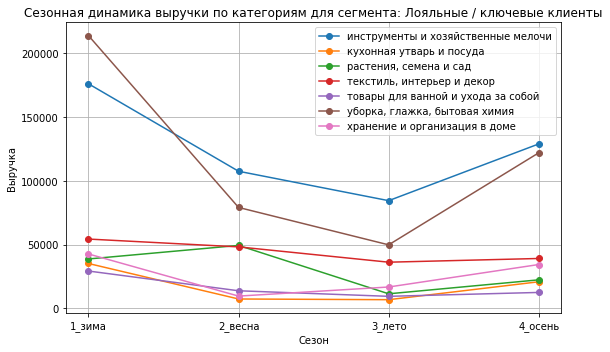

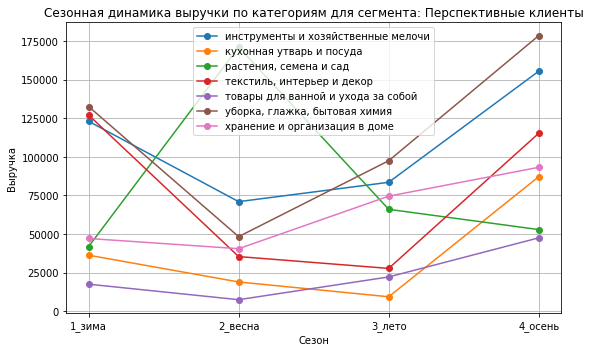

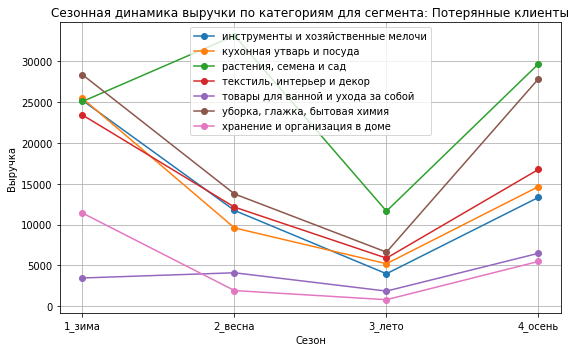

In [94]:
# визуализация
segments = segment_category_season['segment'].unique()

for seg in segments:
    plt.figure(figsize=(8, 5))
    seg_data = segment_category_season[segment_category_season['segment'] == seg]
    
    for cat in seg_data['category'].unique():
        cat_data = seg_data[seg_data['category'] == cat]
        plt.plot(cat_data['season'], cat_data['revenue'], marker='o', label=cat)
    
    plt.title(f'Сезонная динамика выручки по категориям для сегмента: {seg}')
    plt.xlabel('Сезон')
    plt.ylabel('Выручка')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

**Лояльные / ключевые клиенты**

Инструменты и хозяйственные мелочи  
Категория демонстрирует устойчивую сезонность с выраженным пиком зимой, когда покупатели активнее совершают ремонты и бытовые улучшения в помещениях. После зимы спрос постепенно снижается: минимальные продажи приходятся на лето, а затем восстанавливаются осенью. Это типичный паттерн «зимний ремонт — летнее затишье».

Кухонная утварь и посуда  
Здесь также заметен зимний всплеск, вероятно, связанный с праздничным сезоном и подарочными покупками. После зимы спрос резко падает, достигая минимума летом, затем частично восстанавливается осенью, когда клиенты обновляют быт перед холодным сезоном.

Растения, семена и сад  
Категория имеет четкую весеннюю сезонность — пик продаж приходится на весну, отражая естественный спрос на садовые и дачные товары. Зимой и осенью продажи умеренные, а летом наблюдается спад, когда основные посадочные работы уже завершены.

Текстиль, интерьер и декор  
Продажи распределены равномернее, но всё же выше зимой и весной, что можно связать с обновлением интерьера в холодное время года. Лето — период наименьшей активности, тогда как осень показывает лёгкий рост перед праздниками и новым сезоном.

Товары для ванной и ухода за собой  
Спрос также сконцентрирован в зимний период, когда покупатели приобретают больше товаров для ухода и уюта. Весной и осенью наблюдаются умеренные показатели, летом — минимум. Категория имеет стабильную, но слабо выраженную сезонность.

Уборка, глажка и бытовая химия  
Одна из наиболее выраженно сезонных категорий: абсолютный пик продаж — зимой, когда возрастает спрос на чистящие и хозяйственные средства. Весной и осенью активность снижается, а летом достигает минимума. Это подтверждает зимне-весеннюю ориентацию категории.

Хранение и организация в доме  
Здесь заметен осенне-зимний тренд: наибольшие продажи — зимой и осенью, когда покупатели готовятся к холодному периоду и стремятся навести порядок в доме. Весной и летом продажи слабые, что указывает на функциональную сезонность категории.

**Итог по сегменту**    
Для «Лояльных / ключевых клиентов» характерна устойчивая зимняя активность почти во всех категориях, особенно в бытовой химии, инструментах и кухонной утвари. Весенний пик наблюдается лишь в категории «сад и растения», а лето стабильно слабое для всех направлений. Осень играет роль переходного периода — умеренные продажи и подготовка к новому росту зимой.

**Перспективные клиенты**

Инструменты и хозяйственные мелочи  
Самая прибыльная категория в сегменте. Продажи уверенно растут от зимы к осени, достигая максимума в осенний период, что может быть связано с сезонными ремонтами и подготовкой домов к холодам. Весной фиксируется минимальный оборот, затем происходит постепенное восстановление спроса.

Кухонная утварь и посуда  
Категория показывает ярко выраженную осеннюю активность) после низкого летнего спроса. Вероятно, осенний рост связан с обновлением домашней утвари перед холодным сезоном и праздниками. Зимой также наблюдается стабильный интерес, но весной — спад почти вдвое.

Растения, семена и сад  
Как и ожидается, основной всплеск приходится на весну — сезон начала садовых работ. В остальные периоды спрос снижается, но остаётся умеренным даже зимой, что может объясняться покупками комнатных растений и сопутствующих товаров.

Текстиль, интерьер и декор  
Два сезонных пика — зима и осень, что соответствует подготовке к праздникам и обновлению интерьера в холодное время года. Весна и лето проходят с минимальной активностью, что типично для категории «домашнего уюта».

Товары для ванной и ухода за собой  
Выручка постепенно увеличивается от весны. Можно предположить, что осенью клиенты чаще делают крупные покупки для обновления бытовых запасов, а летом — совершают точечные покупки.

Уборка, глажка, бытовая химия  
Похожая динамика: наибольшие обороты осенью и зимой, минимальные — весной. Это указывает на сезонные циклы генеральных уборок — зимнюю (перед праздниками или после) и осеннюю (после лета перед холодным сезоном).

Хранение и организация в доме  
Выручка растёт к концу года, достигая максимума осенью. Летом также фиксируется всплеск, возможно, из-за сезонных разборов и переездов. Весной и зимой активность ниже, но достаточно стабильна.

**Итог по сегменту**  
Для перспективных клиентов общий пик активности приходится на осень, что характерно для покупателей, обустраивающих дом перед холодным сезоном.
Весна выделяется исключительно по категории «растения и сад», тогда как остальные категории демонстрируют либо постепенное увеличение выручки к осени, либо умеренные зимние всплески, связанные с праздниками.

**Потерянные клиенты**

Инструменты и хозяйственные мелочи  
Категория с наибольшей выручкой в сегменте. Наиболее активны зимние месяцы, что может отражать остаточный интерес к утилитарным товарам или покупки «про запас». К лету спрос резко падает, а осенью частично восстанавливается.

Кухонная утварь и посуда  
Динамика схожа: максимум зимой, затем постепенное снижение до минимума летом и частичный рост осенью. Это указывает на то, что данные клиенты совершают покупки скорее в холодный сезон, вероятно, в рамках бытовых обновлений или праздничных закупок.

Растения, семена и сад  
Единственная категория с явным весенним пиком, что логично с точки зрения сезонности. Осенью фиксируется второй, меньший всплеск, тогда как летом и зимой продажи умеренные. Можно предположить, что даже среди ушедших клиентов часть продолжает покупать сезонные товары для сада.

Текстиль, интерьер и декор  
Выручка распределена неравномерно: зима остаётся наиболее активным периодом, а лето — наименее прибыльным . Осенью спрос восстанавливается. Это может говорить о временных возвращениях клиентов для праздничных покупок или сезонных обновлений.

Товары для ванной и ухода за собой  
Самая малодоходная категория в сегменте. Небольшие колебания не создают чёткой сезонной картины, однако осенью фиксируется относительный максимум, что может отражать разовые покупки после длительного перерыва.

Уборка, глажка, бытовая химия  
Категория с умеренной, но стабильной сезонностью. Пики приходятся на зиму и осень , когда традиционно совершаются крупные покупки для генеральных уборок. Весной и летом активность заметно снижается.

Хранение и организация в доме  
Самая слабая категория по вовлечённости: выручка минимальна, особенно летом. Зимний интерес вероятно связан с единичными покупками функциональных товаров. Никакой выраженной сезонной тенденции здесь не прослеживается.

**Итог по сегменту**  
Сегмент «потерянных клиентов» характеризуется общим спадом активности и снижением сезонной отзывчивости. Тем не менее, можно выделить несколько «точек входа» для реактивации:  
зима и осень — для категорий «инструменты», «уборка», «кухонная утварь», «декор»;  
весна и осень — для «растений и сада».  

##### Предварительный итог 5 и маркетинговые рекомендации

**Общий анализ сезонности по категориям и сегментам**

Анализ показывает, что все три сегмента клиентов демонстрируют устойчивую сезонную структуру покупок, но с различной степенью вовлечённости и эмоциональной «температурой» поведения.
Зима и осень остаются самыми прибыльными сезонами для большинства категорий, в то время как весна и лето приносят спад продаж, за исключением очевидных сезонных товаров — прежде всего «растений, семян и сада».

Общие закономерности по категориям:

1. Инструменты и хозяйственные мелочи: у всех сегментов пик активности приходится на зиму и осень. Зимой это покупки для ремонта и мелкого благоустройства, осенью — подготовка к холодному сезону.

2. Кухонная утварь и посуда: одинаково «зимняя» категория во всех сегментах — связана с праздниками, уютом и домашними обновлениями.

3. Растения, семена и сад: чётко весенняя категория. Даже потерянные клиенты частично возвращаются ради сезонных посадок.

4. Текстиль, интерьер и декор: пики зимой и осенью — время обновлений, уюта и праздничного настроения.

5. Товары для ванной и ухода за собой: мягкая сезонность с небольшими зимними и осенними всплесками, отражающими покупки «для себя» и подготовки к праздникам.

6. Уборка, глажка, бытовая химия: стабильные пики зимой и осенью во всех сегментах, совпадающие с периодами генеральных уборок и подготовкой к праздникам.

7. Хранение и организация в доме: выражена осенне-зимняя динамика, слабое лето, что логично — клиенты наводят порядок в доме, когда больше времени проводят внутри.

Таким образом, **осень и зима — универсальные периоды максимальной вовлечённости**.

**Рекомендации по SMS-рассылкам**
1. Лояльные / ключевые клиенты

Профиль: стабильные, делают регулярные заказы, открыты к персонализированным предложениям.
Сезонность: активны осенью и зимой; минимальная активность летом.

Когда писать:  
1. Ноябрь–январь — период пиковых продаж (предновогодний спрос и продажи на новогодних праздниках).  
2. Август–октябрь — плавное «пробуждение» после летнего спада.

Что предлагать:   
1) Товары категорий «уборка, бытовая химия», «инструменты и хозяйственные мелочи», «текстиль и декор».  
2) Наборы и акции «всё для уюта» / «новый год с комфортом».  
3) Премиальные подборки и ранний доступ к распродажам.

Как формулировать SMS:  
Коротко, уважительно, с чувством «особого доступа».

«Любим вас — дарим -15% на всё для зимнего уюта. Только для наших постоянных»  
«Ваша личная распродажа уже началась — загляните первым!»  

Цель: укрепить лояльность, стимулировать дополнительную покупку и удержать внимание в межсезонье.

2. Перспективные клиенты

Профиль: совершают 1–2 покупки, интерес проявляют нерегулярно. Хорошо реагируют на акции и сезонные поводы.
Сезонность: пики весной (категория «сад») и осенью (категории «уборка», «инструменты»).

Когда писать:  
1. Март–апрель — весенние кампании («весеннее обновление», «садовый сезон»).  
2. Октябрь–декабрь — уют, ремонт, обновление быта.

Что предлагать:  
1) Весной: «растения, семена, сад», «инструменты и мелочи».  
2) Летом: "хранение и организация быта".  
3) Осенью и зимой: «уборка, текстиль, интерьер».    
Акции с чётким дедлайном: скидки, купоны на вторую покупку, бонус за возвращение.

Как формулировать SMS:
Живо, конкретно, с эмоциональным акцентом.

«Пора обновить дом! -20% на всё для уюта до воскресенья»
«Вернитесь — подарок ждёт вас! Только до 10 октября »

Цель: вернуть клиента и сформировать привычку регулярных покупок.

3. Потерянные клиенты

Профиль: низкая активность, чаще совершали единичные заказы. Реагируют на простые, понятные поводы.
Сезонность: редкие пики в декабре (праздники) и весной-осенью (садовые товары).

Когда писать:  
1. Февраль–март — реактивация перед весной. 
2. Октябрь - скидки на товары для уборки и растения для дома.
2. Ноябрь–декабрь — напоминание перед праздниками.  

Что предлагать:  
1) Недорогие и универсальные категории: «бытовая химия», «кухонные мелочи», «инструменты», недорогие растения и рассада. 
2) Простые акции без условий: «-10% на всё», «подарок при заказе».  

Как формулировать SMS:
Мягко, без давления, с ощущением заботы.

«Мы скучали 💛 Вернитесь — подарок ждёт вас!»
«Пора заглянуть в “Пока всё ещё тут” — скидка 10% для старых друзей 🏡»

Цель: напомнить о бренде, вызвать доверие и стимулировать хотя бы одно повторное взаимодействие.

[Назад к оглавлению](#оглавление)

<a id='заключение'></a>
## Заключение

**Общий вывод по проекту**

Цель проекта заключалась в сегментации покупателей интернет-магазина товаров для дома и быта «Пока всё ещё тут» на основе их покупательского поведения и подготовке персонализированных рекомендаций для SMS-рассылок. Главная задача — определить, кому, когда и какие категории товаров предлагать, чтобы повысить эффективность коммуникаций, увеличить частоту повторных заказов и вернуть неактивных клиентов.

**Подготовка и очистка данных**

Исходный датасет содержал 7474 строк и 6 столбцов, включавших информацию о заказах, клиентах и товарах. На этапе предобработки данные были очищены, стандартизированы и расширены новыми признаками. Были удалены дубликаты и аномалии, исправлены типы данных, добавлены вычисляемые столбцы (total_cost, month, season), а также проведена категоризация товаров — все позиции были распределены по семи ключевым группам («инструменты и хозяйственные мелочи», «кухонная утварь и посуда», «растения, семена и сад» и др.). После очистки и унификации итоговый датасет насчитывал 5500 строк и 10 столбцов и был полностью готов к исследовательскому анализу.

**Исследовательский анализ данных (EDA)**

На этапе EDA изучены ключевые тенденции продаж, динамика клиентской активности и структура выручки. Анализ показал, что с весны 2019 года выручка постепенно снижалась, несмотря на умеренный рост количества клиентов и заказов. Это указывает на переход покупателей к менее дорогим или единичным покупкам. Средний чек демонстрировал аналогичное снижение с кратковременным ростом в декабре — вероятно, за счёт предновогоднего спроса.

Наибольшую выручку стабильно обеспечивали категории «уборка, глажка, бытовая химия» и «инструменты и хозяйственные мелочи», что отражает устойчивый бытовой спрос. Третье место занимала категория «растения, семена и сад» с ярко выраженной сезонностью. Менее прибыльные категории («товары для ванной», «хранение», «текстиль») приносили меньший оборот, но могли выступать как драйверы возвратов клиентов при грамотном продвижении.

Анализ частоты покупок показал, что 63,7% клиентов совершили только один заказ, а регулярные покупатели (4+ заказа) составляют менее 1%. Это свидетельствует о низкой лояльности и необходимости разработки стратегии удержания.

**RFM-сегментация**

Для оценки клиентской ценности применён RFM-анализ, основанный на трёх метриках:  
1) Recency (R) — давность последней покупки,
2) Frequency (F) — частота покупок,  
3) Monetary (M) — сумма выручки от клиента.

Метрики R и M были разделены по терцилям, а F — по порогу (одна покупка / две и более), что позволило учесть реальное распределение данных и избежать статистического перекоса. На основе присвоенных оценок каждому клиенту был рассчитан интегральный балл RFM_score (от 3 до 8). Это позволило выделить три стратегических сегмента:  
1) Лояльные (7–8 баллов) — частые, недавние и прибыльные клиенты.  
2) Перспективные (5–6 баллов) — средняя активность, нерегулярные заказы.  
3) Потерянные (3–4 балла) — редкие и давно неактивные клиенты с низкой выручкой.

**Проверка статистических гипотез**

Была проведена с помощью теста Краскела–Уоллиса и показала значимые различия между сегментами как по среднему чеку, так и по количеству заказов (p-value < 0.05), что подтверждает обоснованность выделения групп.

**Выводы и рекомендации по сегментам**

1. Лояльные / ключевые клиенты

Описание:
Это наиболее ценный сегмент — около четверти базы (26%), формирующий 38% всей выручки. Покупают регулярно, делают в среднем 2 заказа, со средним чеком 2393 руб., что является самым высоким показателем среди всех групп.
Выбирают несколько категорий одновременно — инструменты, кухонную утварь, бытовую химию, текстиль и декор.

Поведение и сезонность:
Пик активности приходится на зимне-осенний период, особенно декабрь и сентябрь–октябрь, когда клиенты обновляют дом и совершают праздничные покупки. Летом — заметный спад.

Рекомендации:

Коммуникации планировать на ноябрь–январь и август–октябрь.

Предлагать премиальные подборки и сезонные комплекты для обустройства дома.

Использовать персональный тон и эксклюзивные обращения («только для вас», «доступно первым»).

Основная цель — удержание регулярности покупок и рост среднего чека за счёт допродаж и подарочных предложений.

2. Перспективные клиенты

Описание:
Это самый крупный сегмент (39% клиентов), обеспечивающий 52% выручки. Совершают покупки менее регулярно, чем лояльные клиенты (в среднем 1,4 заказа) и реже возвращаются (в среднем перерыв в покупках составляет 223 дня), но средний чек остаётся высоким — 2155 руб.
Активно реагируют на акции и сезонные предложения. Основные категории — инструменты, товары для дома и интерьера, сад и растения.

Поведение и сезонность:
Наибольшая активность наблюдается осенью и зимой (особенно во время распродаж и праздников), а также весной по категории «сад и растения».

Рекомендации:

Делать акцент на садовые товары в марте-апреле и на подарки и товары для дома в октябре–декабре (если есть бюджет, то летом-осенью на товары для хранения и организации быта).

Продвигать громкие, заметные акции, комплекты для дома (в разных категориях - текстиль, дизайн, инструменты), бонусы за повторный заказ.

Коммуникации — динамичные и мотивирующие («успей до конца недели», «вернись за уютом»).

Цель — повысить частоту покупок и сформировать привычку возвращаться в магазин.

3. Потерянные клиенты

Описание:
Это самый неактивный сегмент, доля которого при этом выше доли лояльных клиентов (35%), приносящий лишь 10% выручки. Средний чек — 454 руб., обычно только один заказ, средний интервал между покупками — 322 дня. Несмотря на низкую активность, сохраняют сезонный интерес зимой и весной.
Основные категории — лидируют сад и растения, затем идут инструменты, бытовая химия, кухонная утварь.

Поведение и сезонность:
Покупки совершаются в декабре–марте, в остальное время — практически отсутствуют, за исключением товаров для сада, пик интереса к которым приходится на весну и осень.

Рекомендации:

Проводить реактивацию осенью и летом для товаров категории "растения и сад", а в феврале–марте и в ноябре (новогодние закупки) - для других упоминаемых категорий тоже.

Предлагать доступные и практичные товары повседневного спроса.

Использовать мягкий, дружелюбный тон («мы скучали», «у нас для вас подарок»).

Цель — восстановить контакт с брендом и стимулировать хотя бы одно повторное взаимодействие.